In [1]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [2]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [3]:
def evaluate_ets(npa_):
    train,test,model_func,flag_ = npa_
    
    try:
        if(len(flag)==2):
            if(flag[1] is None):
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=train.index).fit()
            else:
                model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=train.index).fit()
        else:
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=train.index).fit()

        fc_ets_ = np.exp(model.get_prediction(start=test.index[0],end=test.index[-1]).summary_frame())
        rmse_ = mean_squared_error(test, fc_ets_['mean'], squared=True)
    except:
        #not enough data points
        rmse_ = np.nan
    
    return([flag,rmse_])

In [4]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [5]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [6]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [7]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [8]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [9]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [10]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [11]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [12]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [13]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [14]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

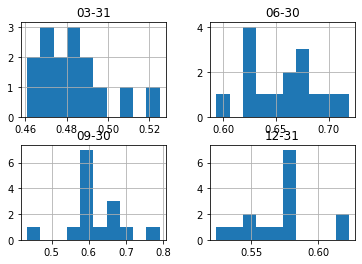

In [15]:
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()

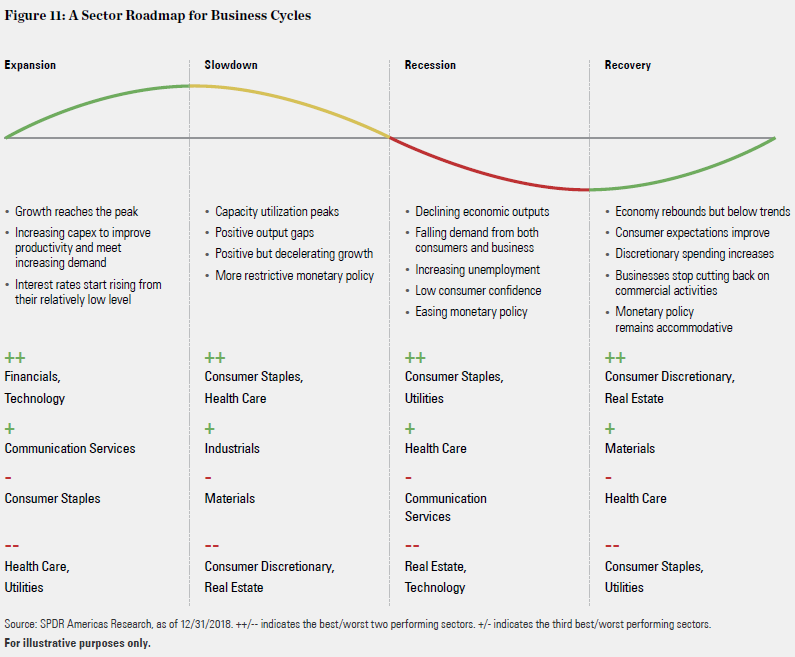

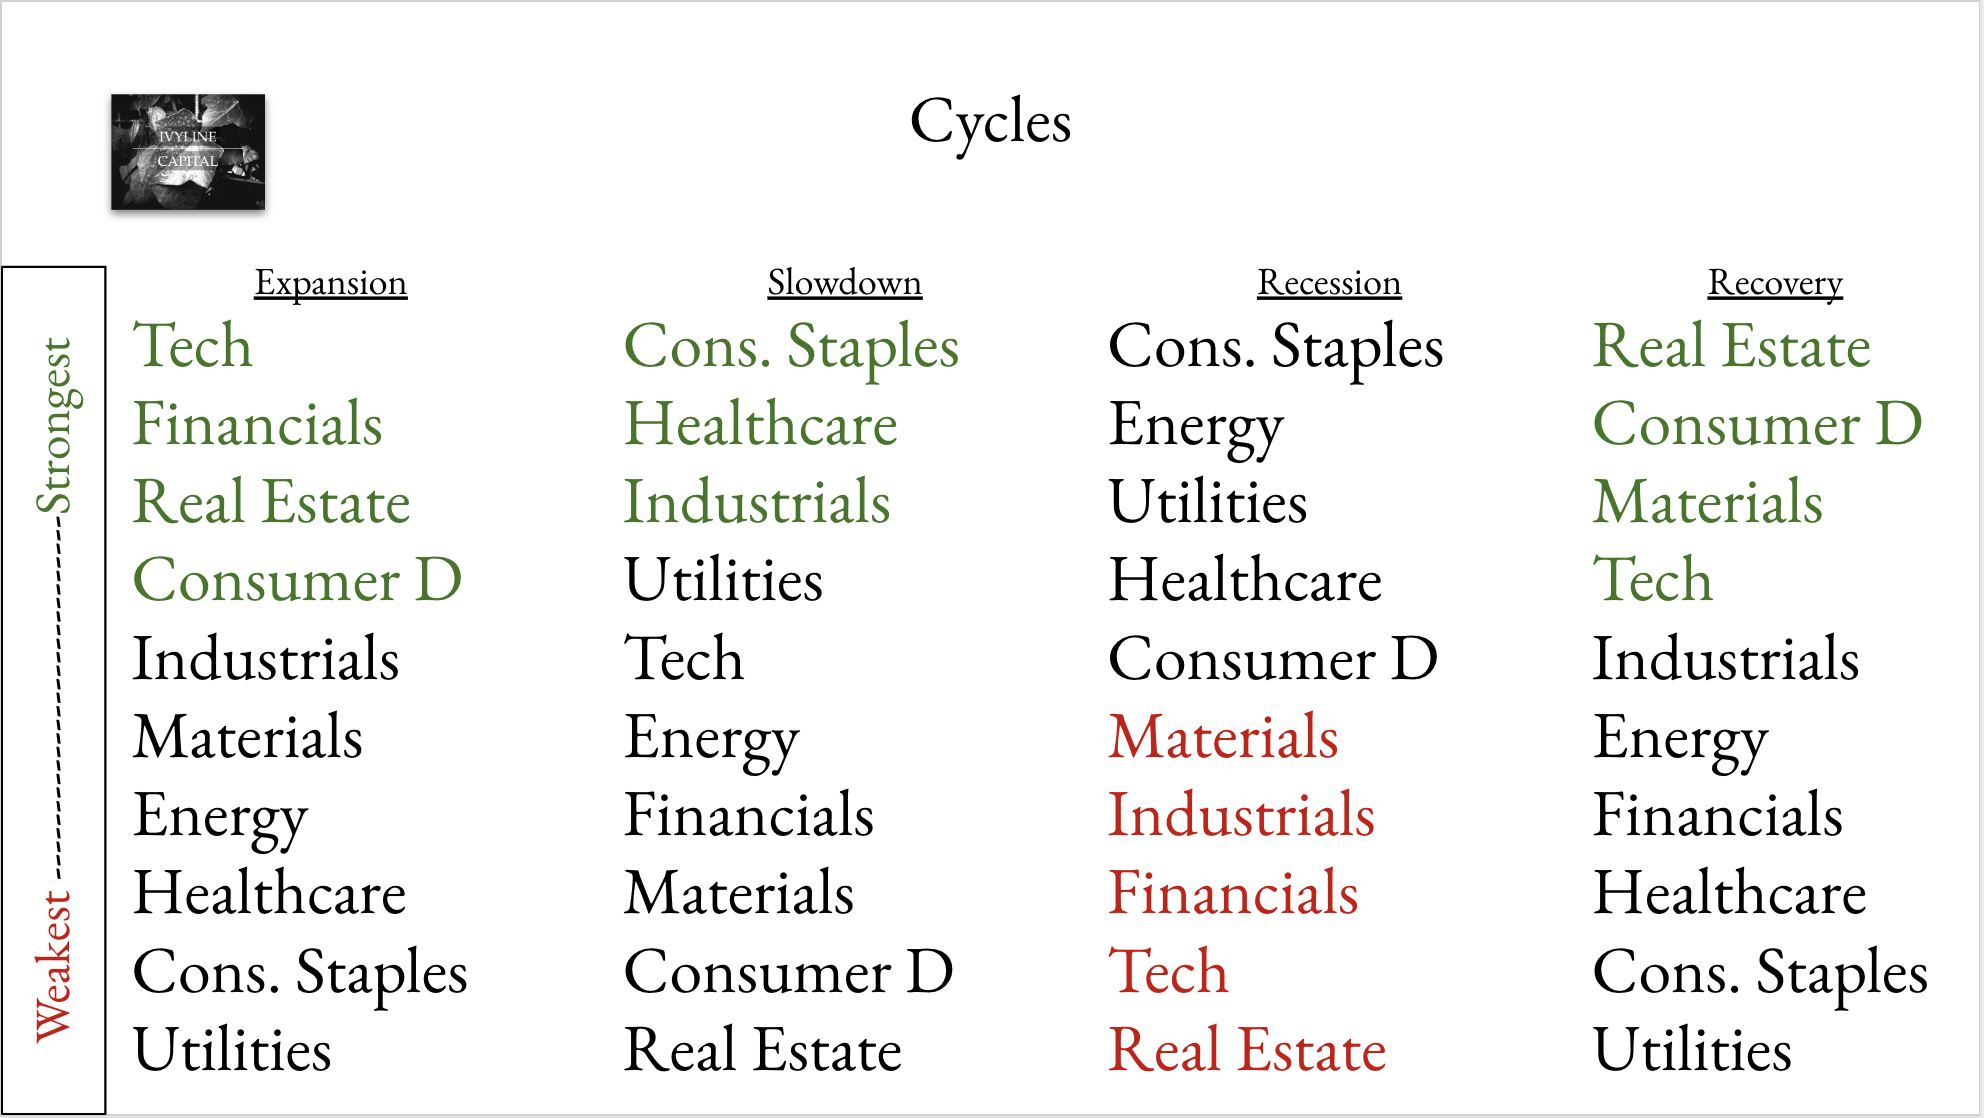

In [16]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [17]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


In [18]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [19]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

Index Symbol  risk_trend_factor
0   SP500    SPY          -3.791861
1  SP1500   SPTM          -3.879022
2   SP400   MDYG          -5.134573
3   SP600    SLY          -5.242200

In [20]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

Symbol  risk_trend_factor                      Sector
3     VDE          -0.123306                  Energy ETF
2     VDC          -2.283970        Consumer Staples ETF
10    VPU          -2.520459               Utilities ETF
9     VNQ          -3.053370             Real Estate ETF
8     VAW          -3.165271               Materials ETF
5     VHT          -3.323632             Health Care ETF
6     VIS          -4.514668             Industrials ETF
4     VFH          -4.617891              Financials ETF
1     VCR          -4.721407  Consumer Discretionary ETF
7     VGT          -4.954472  Information Technology ETF
0     VOX          -8.783598  Communication Services ETF

Rolling Quarterly Mean Return


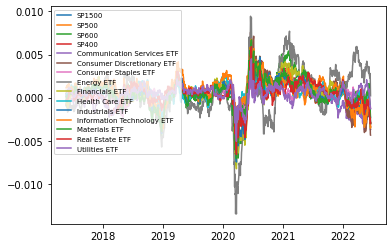

In [21]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


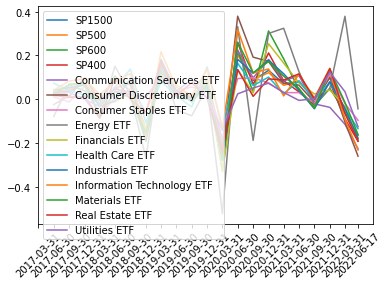

In [22]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


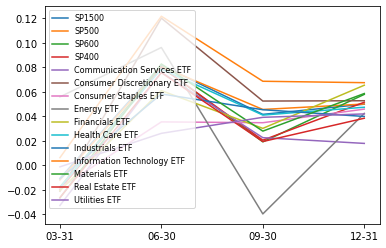

In [23]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [24]:
threshold = .975

In [25]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [26]:
risk_trend_threshold

0.051078501531639196

In [27]:
stock_sectors = stock_fundamentals['sector']

In [28]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

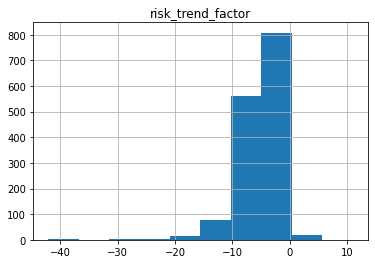

In [29]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [30]:
len(screener)

1520

In [31]:
prices_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'trailing_1yr_max', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'trailing_1yr_min', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'trailing_60d_max',
       'trailing_60d_min', 'trailing_30d_max', 'trailing_30d_min', '90dSMA',
       '90dSDev', 'TP', '21dstdTP', '21dMA-TP', '21dBOLU', '21dBOLD',
       'trailing_risk_40d_max', 'trailing_risk_40d_min', 'risk_per_share',
       '30d_vol', '30d_vol_2yr', 'volume_factor', '1YMF', 'risk_trend_factor'],
      dtype='object')

In [32]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
temp_df = risk_screened[['Symbol','latest_p','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','volume_factor','adf','hurst','Sector','Market Index']]
temp_df.set_index('Symbol',inplace=True)
pd.concat([temp_df,temp_sm],axis=0)

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'volume_factor', 'adf', 'hurst',
       '1YMF', 'Market Index', 'Sector'],
      dtype='object')


latest_p MIN_Lookback_One_Year MIN_Lookback_2_Months  \
Symbol                                                          
ACC     64.230003             49.209999             65.019997   
MTOR    35.939999                 32.93             36.279999   
TVTY    32.130001             27.870001             32.889999   
BANF    94.860001             77.379997                 86.82   
Y           830.5            737.890015            862.869995   
...           ...                   ...                   ...   
ODFL          NaN                   NaN                   NaN   
EW            NaN                   NaN                   NaN   
PCRX          NaN                   NaN                   NaN   
CBOE          NaN                   NaN                   NaN   
PCAR          NaN                   NaN                   NaN   

       MIN_Lookback_1_Months risk_trend_factor volume_factor       adf  \
Symbol                                                                   
ACC                65.019997         10.926848      2.134689  0.978004   
MTOR               36.279999          5.065223      1.664475  0.319063   
TVTY               32.889999          2.341879      1.643789  0.518794   
BANF                   86.82          2.011991      1.135864  0.955166   
Y                 862.869995          1.771776       1.56538  0.382688   
...                      ...               ...           ...       ...   
ODFL                     NaN         -5.178995           NaN       NaN   
EW                       NaN         -2.677285           NaN       NaN   
PCRX                     NaN         -2.849253           NaN       NaN   
CBOE                     NaN         -4.539896           NaN       NaN   
PCAR                     NaN         -4.010257           NaN       NaN   

           hurst              Sector Market Index  index index_Symbol  
Symbol                                                                 
ACC     0.420279         Real Estate        SP400    NaN          NaN  
MTOR     0.43585               error        SP600    NaN          NaN  
TVTY    0.448871               error        SP600    NaN          NaN  
BANF    0.536352               error        SP600    NaN          NaN  
Y       0.459685  Financial Services        SP400    NaN          NaN  
...          ...                 ...          ...    ...          ...  
ODFL         NaN         Industrials          NaN  SP500          SPY  
EW           NaN          Healthcare          NaN  SP500          SPY  
PCRX         NaN          Healthcare          NaN  SP600          SLY  
CBOE         NaN  Financial Services          NaN  SP500          SPY  
PCAR         NaN         Industrials          NaN  SP500          SPY  

[1555 rows x 12 columns]

In [33]:

screened_final_set = risk_screened

In [34]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [35]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [36]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [37]:
summary = pd.DataFrame()

In [62]:
summary = pd.DataFrame()
for name_ in np.unique(prices_df['Symbol'].values):
    summary = pd.concat([summary,pd.DataFrame(prices_df[prices_df['Symbol']==name_][['Symbol','MIN_Lookback_One_Year', 'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months','risk_trend_factor','risk_per_share','volume_factor']].iloc[-1]).T.reset_index().set_index('Symbol')],axis=0)



In [64]:
threshold=.95

In [65]:
threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

temp_sm

In [66]:
summary

index MIN_Lookback_One_Year MIN_Lookback_2_Months  \
Symbol                                                          
A      2022-06-17            147.679993            179.570007   
AA     2022-06-17             44.419998             98.089996   
AAL    2022-06-17             22.549999             22.549999   
AAN    2022-06-17                   NaN             35.439999   
AAON   2022-06-17                 81.25             83.790001   
...           ...                   ...                   ...   
ZIMV   2022-06-17                   NaN                   NaN   
ZION   2022-06-17             60.650002             75.440002   
ZTS    2022-06-17            187.320007            249.270004   
ZUMZ   2022-06-17             50.060001             55.099998   
ZYXI   2022-06-17             16.263636             16.263636   

       MIN_Lookback_1_Months risk_trend_factor risk_per_share volume_factor  
Symbol                                                                       
A                 179.570007         -9.088903      18.559998      1.131711  
AA                 98.089996         -3.704472      25.040001       0.98632  
AAL                22.549999         -3.126898       9.219999      0.707794  
AAN                35.439999               NaN       6.969999           NaN  
AAON               83.790001         -10.22921       9.380001      1.041044  
...                      ...               ...            ...           ...  
ZIMV                     NaN               NaN           7.92           NaN  
ZION               75.440002         -4.600841      11.900002      0.978199  
ZTS               249.270004          -6.71488      31.180008      1.095466  
ZUMZ               55.099998         -5.921479      12.989998      1.674903  
ZYXI               16.263636        -10.695845           2.43      0.673641  

[1519 rows x 7 columns]

In [42]:
temp_sm.columns

Index(['risk_trend_factor', 'Sector', 'index', 'index_Symbol'], dtype='object')

In [43]:
risk_trend_factor_sector_dict = dict()
for s in sectors['Symbol']:
    risk_trend_factor_sector_dict[s] = prices_df[prices_df['Symbol']==s]['risk_trend_factor'].values[-1]
    
risk_trend_factor_sector_dict['error']='error'    

In [44]:
inv_dict_map = {v: k for k, v in dict_indexes.items()}
inv_dict_map[np.nan] = 'error'
in_ = [inv_dict_map[t[0]] for t in temp_sm[['index']].values]
se_ = [dict_sectors[t[0]] for t in temp_sm[['Sector']].values]
#temp_sm[['Sector','index']]
symbols_w_index_sector = pd.concat([pd.DataFrame(se_,columns=['index'],index=temp_sm.index),pd.DataFrame(in_,columns=['sector'],index=temp_sm.index)],axis=1)

In [45]:
symbols_w_sector_rtf = pd.DataFrame([risk_trend_factor_sector_dict[s] for s in symbols_w_index_sector['index'].values],columns=['sector_risk_trend_factor'],index=symbols_w_index_sector.index)

In [46]:
rick_screener = pd.concat([summary.sort_values(by='risk_trend_factor',ascending=False).iloc[:,1:],symbols_w_index_sector,symbols_w_sector_rtf,temp_sm[['index','Sector']]],axis=1)

In [47]:
rick_screener_final = rick_screener.dropna()[rick_screener.dropna()['risk_trend_factor'].values > threshold_value.values[0]]

In [48]:
rick_screener_final

MIN_Lookback_One_Year MIN_Lookback_2_Months MIN_Lookback_1_Months  \
Symbol                                                                     
ACC                49.209999             65.019997             65.019997   
MTOR                   32.93             36.279999             36.279999   
TVTY               27.870001             32.889999             32.889999   
BANF               77.379997                 86.82                 86.82   
Y                 737.890015            862.869995            862.869995   
SAFM              177.479996                 200.0                 200.0   
SJI                    29.24                 35.32                 35.32   
LNTH               25.790001             64.139999             69.738998   
ROG               206.130005             274.51001             274.51001   
TWI                    11.82                 15.77             18.889999   
PBF                18.780001             30.129999                 32.41   
GO                     36.77                 36.77                 37.82   
HRB                    26.23                 28.17             34.959999   
AZPN              162.559998            169.220001            191.460007   
CEIX                   18.93             50.389999             55.259998   
PSB               165.850006            189.229996            189.830002   
MCK               204.660004            333.440002            339.940002   
GCP                27.780001             32.279999             32.279999   
WRB                54.953335             71.269997             71.529999   
FCN               147.380005            167.279999            170.649994   
XOM                64.800003             91.510002             92.919998   
MANT                    92.0                  92.0             94.730003   
SM                 24.780001             43.689999             43.689999   
DINO               39.389999             40.950001             48.290001   
PLAB                   14.56             20.299999             20.299999   
MPC                64.839996             91.879997             98.290001   
LLY               235.850006                 314.0                 314.0   
VLO                84.949997            111.519997            131.690002   
APA                24.299999             45.220001                 45.27   
PPC                26.280001             29.700001             30.559999   
MRO                    14.16             27.719999                  29.0   
DVN                    31.99             64.980003                 73.18   
UTHR              212.619995            218.380005            218.380005   
VIVO               27.450001             28.719999             28.719999   
ROCC                   25.59                 42.66                 42.66   
COP                61.779999            107.519997            108.300003   
OXY                    32.52             63.240002             69.169998   
MGPI                   76.68             97.610001                 104.0   

       risk_trend_factor volume_factor  index sector sector_risk_trend_factor  \
Symbol                                                                          
ACC            10.926848      2.134689    VNQ   MDYG                 -3.05337   
MTOR            5.065223      1.664475  error    SLY                    error   
TVTY            2.341879      1.643789  error    SLY                    error   
BANF            2.011991      1.135864  error    SLY                    error   
Y               1.771776       1.56538    VFH   MDYG                -4.617891   
SAFM            1.751569      1.334104    VDC   MDYG                 -2.28397   
SJI             1.295238      0.791297  error    SLY                    error   
LNTH            1.178774      1.823238    VHT    SLY                -3.323632   
ROG             1.068804      0.980653  error    SLY                    error   
TWI             0.931088      1.389288    VIS    SLY                -4.5146

In [49]:
rick_screener_final.to_csv('rick_screener_final.csv')

In [50]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

nominal, pct_change, pct_change().cumsum
Market volatility


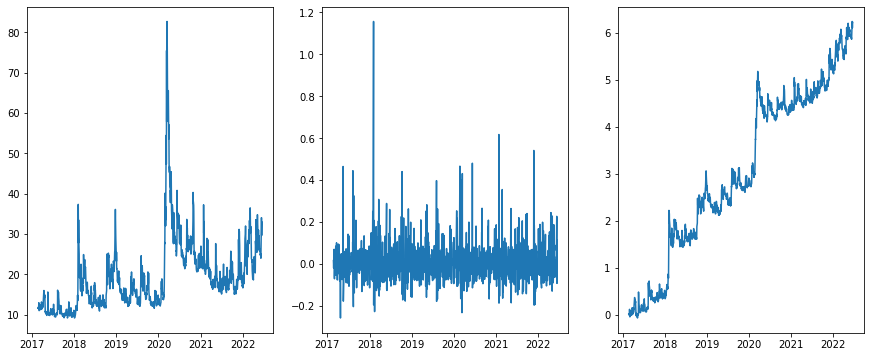

Consumer Confidence


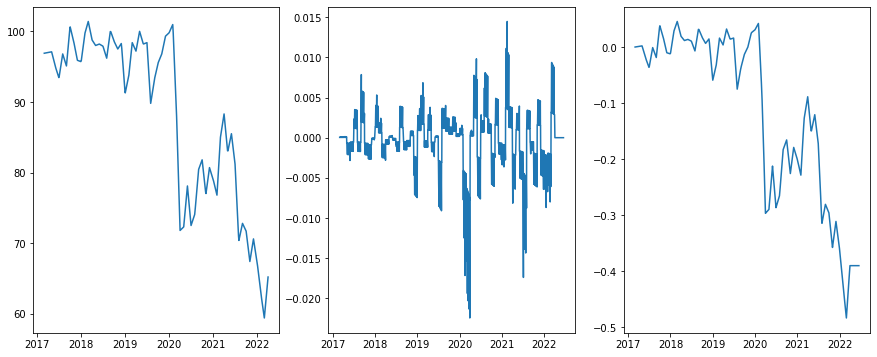

Unemployment


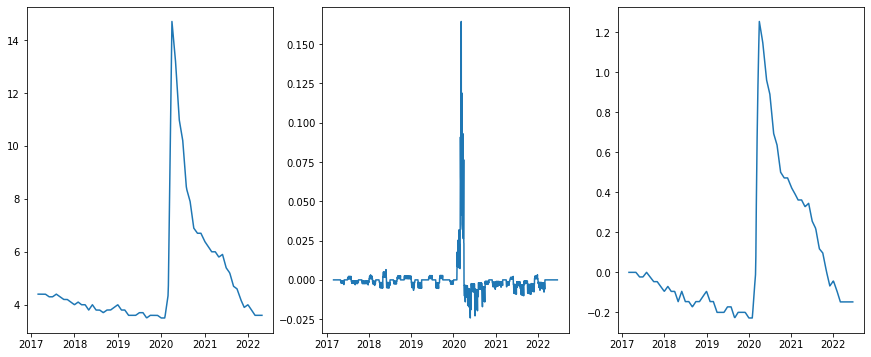

Inflation


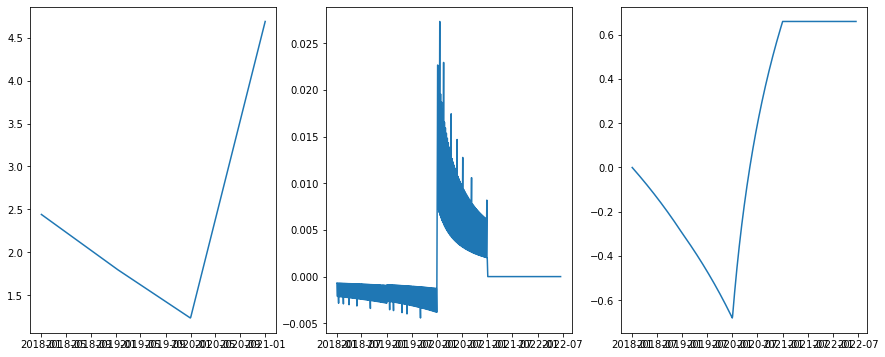

Interest Rates


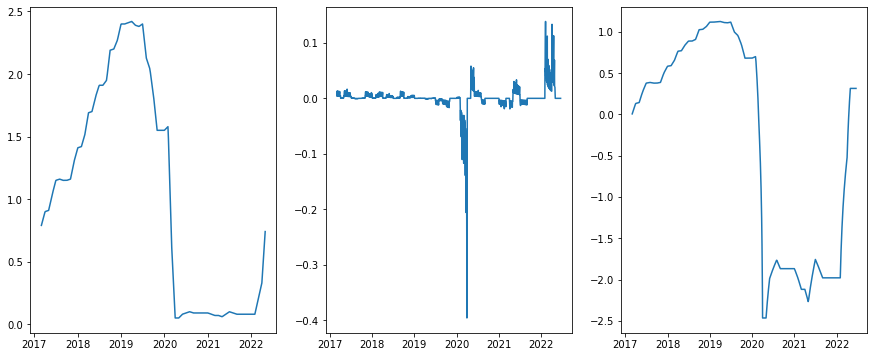

10 Year to 3 Month


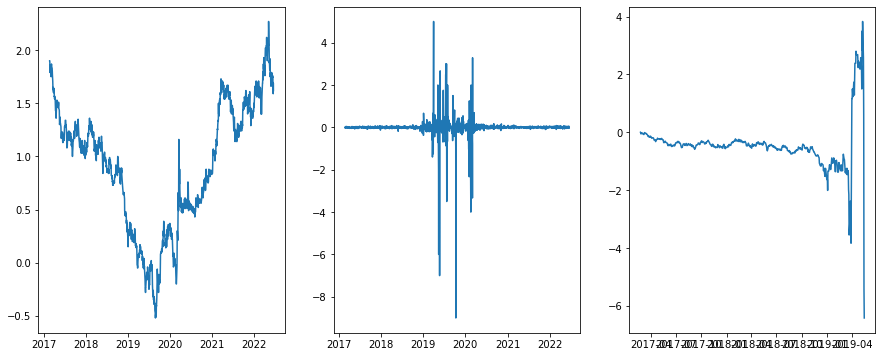

Recession Indicator


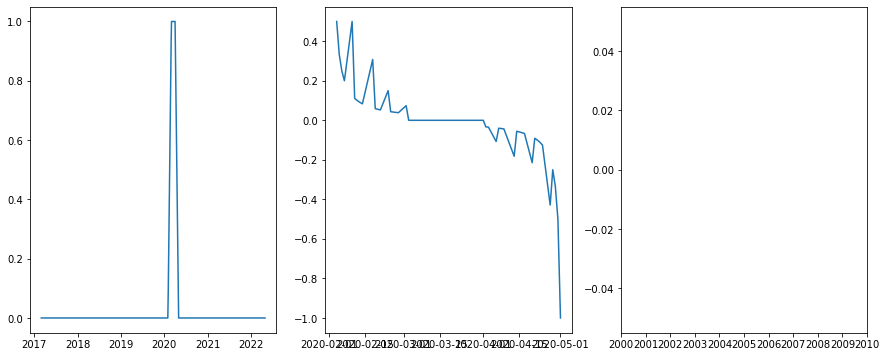

In [51]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [52]:
#screener['vol_30d_2yr']

In [53]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['latest_p'].loc[decision_metrics_df.index]

In [57]:
#list__ = ['MCK','MPC','APA','LNTH','MUSA','CIVI','VAW','VGT','EQT','XOM','DVN','MRO','EOG','HES','CEIX','SM','RRC','MUR','MTDR','PXD','OXY','PDCE','NFG','FANG','TWI','PBF','MANT','HRB','VDC','ACC','GO','TVTY','FCN','VIVO']

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: MCK
sector: Healthcare
Index: SP500
vol_30d_2yr: 22868822.0703125
Sector 1YMF: 23.670013427734375
1YMF: 23.670013427734375
risk trend factor: 0.5738185073390152
         beta currentRatio dividendRate dividendYield      ebitda  \
MCK  0.716666         0.98         1.88        0.0058  3516999936   

    ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
MCK       0.01368  13.643667   2778374912       0.0503  11967000000   

    heldPercentInstitutions              industry    marketCap  \
MCK                   0.898  Medical Distribution  45891629056   

    operatingCashflow operatingMargins payoutRatio pegRatio  \
MCK        4917000192           0.0105      0.2521     1.05   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MCK                     0.178562       0.

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  300.570007  299.443248  318.421081  337.398913  317.445859   

              90dSDev   90d_lower   90d_upper  
2022-06-17  10.066372  297.313115  337.578604

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MCK      1.048139  300.570007  22868822.070312  0.803327  0.997242  0.461301

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


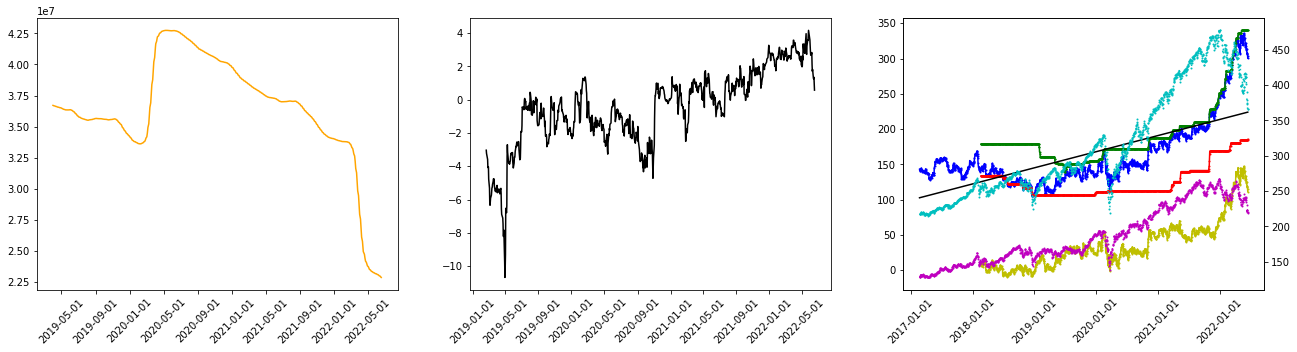

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 416.2961230815321 356.8369096947936
test cv mean error, stdev (10 folds): 436.74552730928997 368.0569226795546
sell date: 2022-09-16
expected return: 0.046541229760563754
discounted return: 0.0005055795388559936
quarter return: 1.047599716932342


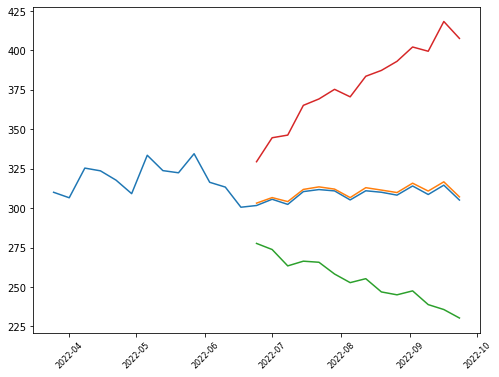

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          2.130000e+09  2.385000e+09  2.797000e+09   
Capital Surplus            7.411000e+09  7.311000e+09  7.057000e+09   
Total Liab                 6.449500e+10  6.368800e+10  6.293200e+10   
Total Stockholder Equity  -1.274000e+09 -5.710000e+08 -5.290000e+08   
Minority Interest          4.870000e+08  4.840000e+08  4.910000e+08   
Other Current Liab         5.975000e+09  3.504000e+09  6.850000e+08   
Total Assets               6.370800e+10  6.360100e+10  6.289400e+10   
Common Stock               2.000000e+06  2.000000e+06  2.000000e+06   
Other Current Assets       5.940000e+09  3.470000e+09  1.230000e+08   
Retained Earnings          8.734000e+09  8.812000e+09  8.618000e+09   
Other Liab                 1.007600e+10  9.988000e+09  1.065700e+10   
Good Will                  9.462000e+09  9.473000e+09  9.520000e+09   
Treasury Stock            -1.742100e+10 -1.669600

Adj Close    21dBOLD    21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-17  87.290001  89.493723  102.090159  114.686595  92.392331  8.807067   

            90d_lower   90d_upper  
2022-06-17  74.778196  110.006465

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
MPC      1.221452  87.290001  141817662.109375  0.691764  0.549549  0.514371

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


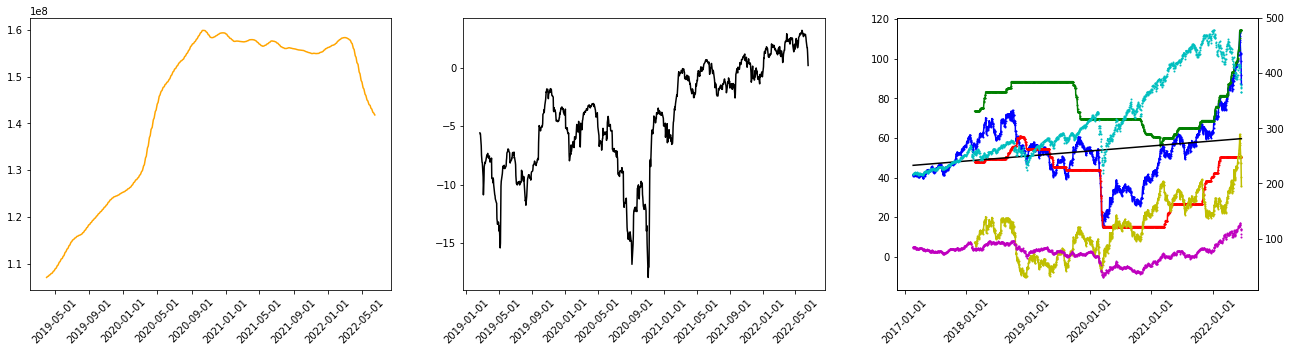

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 143.40338803089983 157.9285356235044
test cv mean error, stdev (10 folds): 150.67304196295433 163.87263524573171
sell date: 2022-06-24
expected return: 0.00655156980504667
discounted return: 0.0010889594114129597
quarter return: 1.1053143311738611


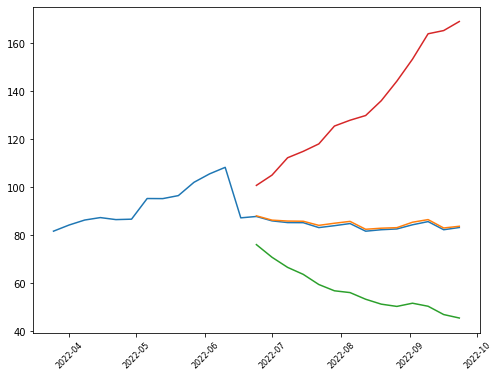

['options', ('2022-07-15', '2022-09-16', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.01
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        5.87
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              28.78
highestControversy                        3
esgPerformance                     AVG_PERF
coal                           

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  39.220001  39.703868  46.051746  52.399625  42.946032  3.294685   

            90d_lower  90d_upper  
2022-06-17  36.356662  49.535402

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
APA      0.999608  39.220001  204531248.4375  0.713933  0.302651  0.445144

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


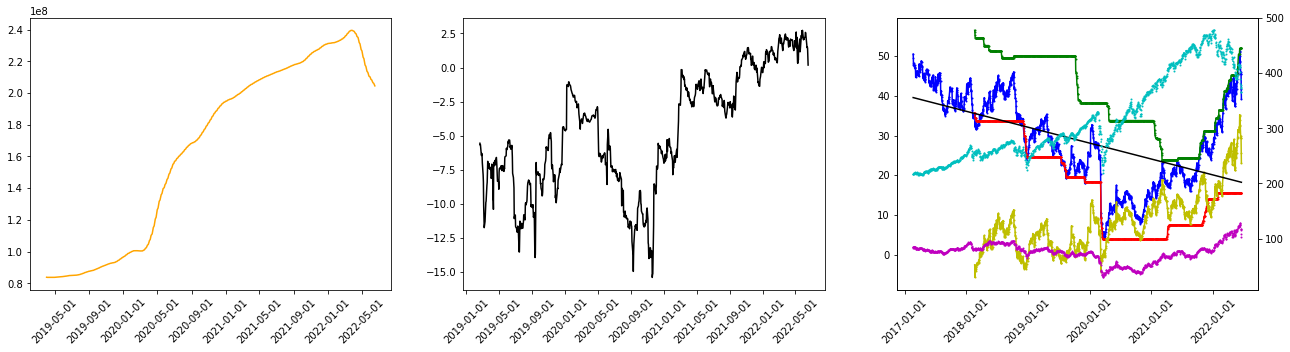

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 47.195177513702305 46.89689483945972
test cv mean error, stdev (10 folds): 51.47031839827251 47.09783187577595
sell date: 2022-09-02
expected return: 0.1861923039791639
discounted return: 0.002249215599403165
quarter return: 1.229608063257754


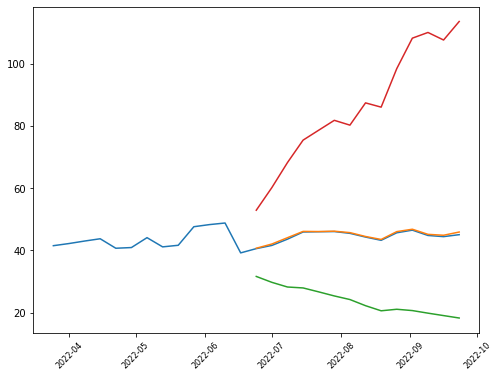

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   1.164500e+10  1.168600e+10  1.170400e+10   
Total Liab                        1.330800e+10  1.270500e+10  1.281900e+10   
Total Stockholder Equity         -1.595000e+09 -1.095000e+09 -9.640000e+08   
Minority Interest                 1.590000e+09  1.580000e+09  1.657000e+09   
Deferred Long Term Liab           5.700000e+08  5.150000e+08  5.120000e+08   
Other Current Liab                3.370000e+08  2.760000e+08  2.990000e+08   
Total Assets                      1.330300e+10  1.331000e+10  1.351200e+10   
Common Stock                      2.620000e+08  2.620000e+08  2.620000e+08   
Other Current Assets              1.550000e+08  1.020000e+08  7.600000e+07   
Retained Earnings                -9.488000e+09 -9.870000e+09 -9.757000e+09   
Other Liab                        3.744000e+09  3.673000e+09  2.626000e+09   
Treasury Stock                   -4.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  60.720001  58.693247  66.262412  73.831578  61.742857  5.236883   

            90d_lower  90d_upper  
2022-06-17  51.269091  72.216623

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
LNTH      1.823238  60.720001  14149384.179688  0.79355  0.965336  0.533209

Sector 1YMF: -122.20997619628906
Sector Volume Factor: 1.2238851152317325
Sector Risk Trend Factor: -3.3236323632363236
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


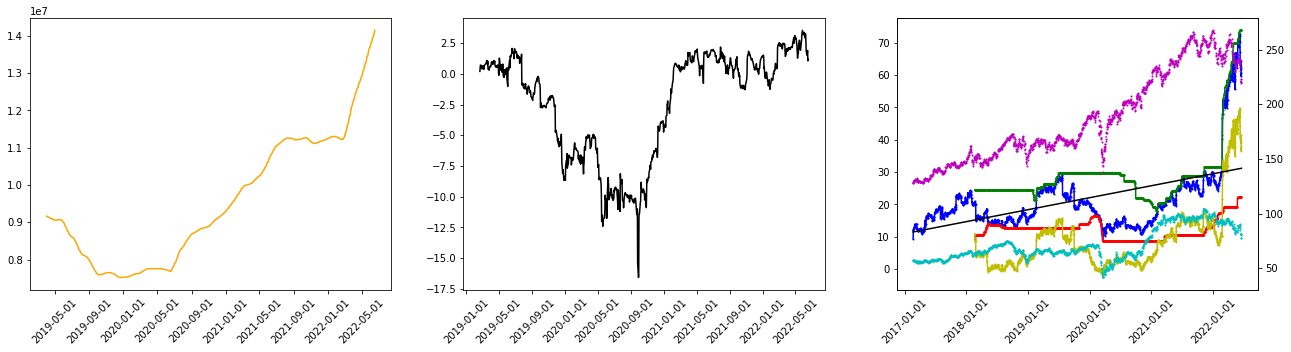

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 44.12135416232843 56.91591688464688
test cv mean error, stdev (10 folds): 42.361417550444955 59.40784968218662
sell date: 2022-09-16
expected return: 0.27426643449919397
discounted return: 0.002696636818909859
quarter return: 1.2811481683424715


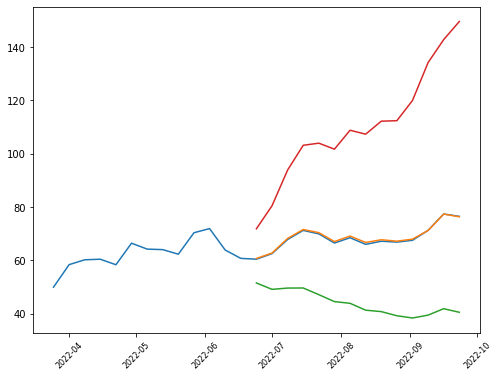

['quarterly_balance_sheet',                                    2022-03-31   2021-12-31   2021-09-30  \
Intangible Assets                 340204000.0  348510000.0  356883000.0   
Capital Surplus                   691516000.0  685472000.0  680819000.0   
Total Liab                        417316000.0  399345000.0  348472000.0   
Total Stockholder Equity          515850000.0  464439000.0  499344000.0   
Other Current Liab                 89178000.0          NaN          NaN   
Total Assets                      933166000.0  863784000.0  847816000.0   
Common Stock                         686000.0     677000.0     677000.0   
Other Current Assets               12860000.0    2705000.0   12043000.0   
Retained Earnings                -178263000.0 -221225000.0 -181010000.0   
Other Liab                         64083000.0  129181000.0   88437000.0   
Good Will                          61189000.0   61189000.0   61189000.0   
Treasury Stock                      1911000.0    -485000.0   -1142000.0 

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  219.949997  223.738215  240.378096  257.017977  230.259682   

              90dSDev   90d_lower   90d_upper  
2022-06-17  18.979918  192.299846  268.219518

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MUSA      1.334565  219.949997  5753261.328125  0.722226  0.983263  0.407464

Sector 1YMF: -359.96002197265625
Sector Volume Factor: 1.2928194874233667
Sector Risk Trend Factor: -4.72140697901556
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


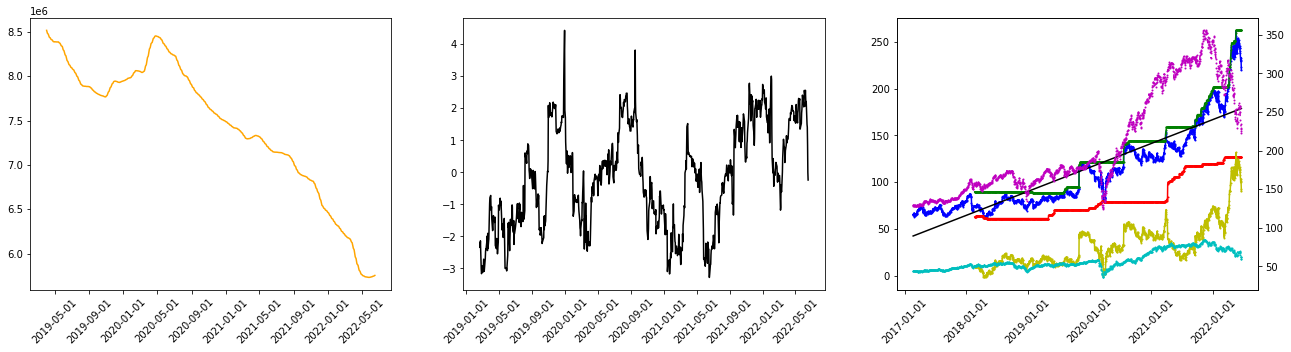

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 715.3257877915737 661.0824735901656
test cv mean error, stdev (10 folds): 648.0064692676062 656.4161823927838
sell date: 2022-08-26
expected return: 0.05475904776484405
discounted return: 0.0007729413203565461
quarter return: 1.0736704801054706


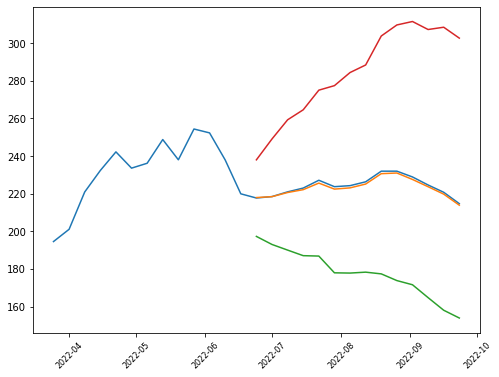

['options', ('2022-07-15', '2022-11-18')]
symbol: CIVI
sector: Energy
Index: SP600
vol_30d_2yr: 11280458.3984375
Sector 1YMF: -4.769992828369141
1YMF: -4.769992828369141
risk trend factor: -0.16120284517848887
         beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
CIVI  1.69646        0.505       11.399         1.85        0.0308  910931008   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CIVI       0.54408  4.123542    855249152      0.79951    731177000   

     heldPercentInstitutions       industry   marketCap operatingCashflow  \
CIVI                 1.04414  Oil & Gas E&P  5104847872         764176000   

     operatingMargins payoutRatio pegRatio priceToBook  \
CIVI          0.26443      0.2792     0.33    1.100427   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
CIVI                     3.049008       0.16167      0.477        0.06714   

     returnOnEquity revenueGrowth revenuePerShare  sector

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  60.080002  60.574303  74.092381  87.610459  65.567778  7.658155   

            90d_lower  90d_upper  
2022-06-17  50.251469  80.884087

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
CIVI      1.757641  60.080002  11280458.398438  0.651117  0.000393  0.470352

ADFuller H0 rejected @ .05, Mean Reverting TS
Month Mean Reverting buy signal


Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


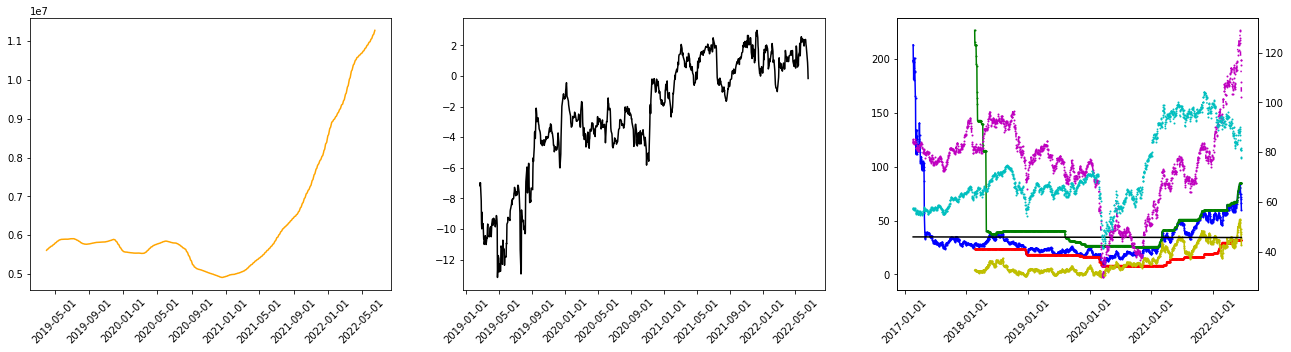

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'mul', True]
best inner cv score, sdev (11 folds): 57.075279509174884 43.09794821567233
test cv mean error, stdev (10 folds): 61.65999162393663 42.56713636729819
sell date: 2022-09-23
expected return: 0.0002458549281730644
discounted return: 2.5342785803239565e-06
quarter return: 1.0002331805163032


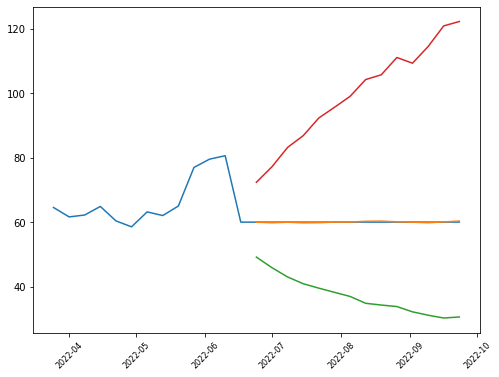

['options', ('2022-07-15', '2022-12-16')]
symbol: VAW
sector: error
sector: Basic Materials
Index: nan
vol_30d_2yr: 2683599.21875
Sector 1YMF: -109.739990234375
1YMF: -109.739990234375
risk trend factor: -3.165271062358118
      totalAssets
VAW  5.085875e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  162.800003  163.360294  181.546031  199.731768  187.277779   

             90dSDev   90d_lower   90d_upper  
2022-06-17  8.558355  170.161068  204.394489

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf    hurst
VAW      1.040096  162.800003  2683599.21875  0.553392  0.650248  0.42433

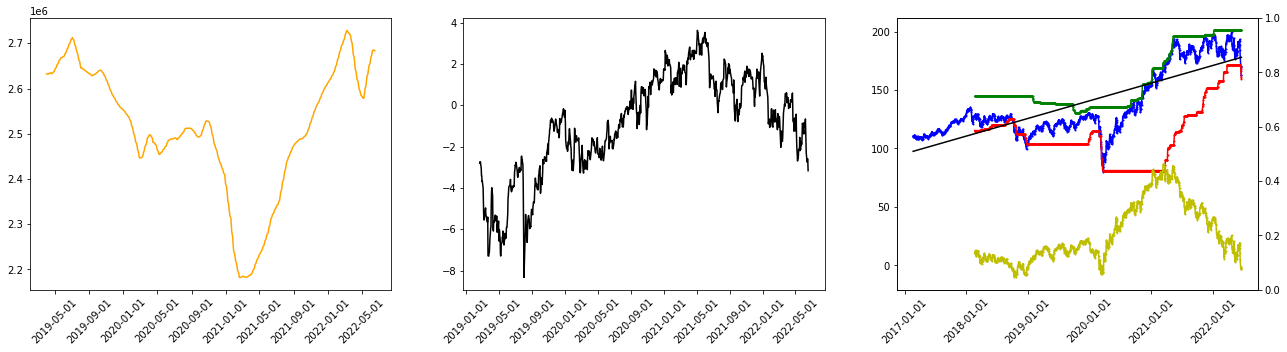

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 287.23750917230495 405.64150386955856
test cv mean error, stdev (10 folds): 311.0194779196468 418.06474405516997
sell date: 2022-07-22
expected return: 0.062301865982123776
discounted return: 0.001779172775185911
quarter return: 1.1776706438001052


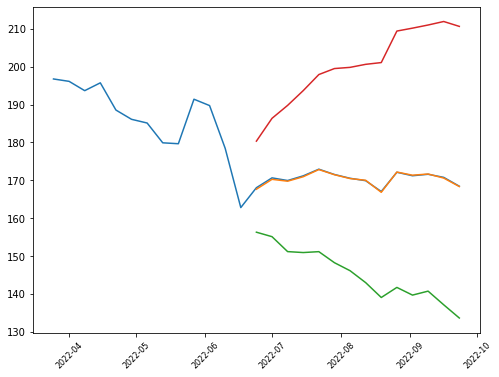

['options', ('2022-08-19',)]
symbol: VGT
sector: error
sector: Technology
Index: nan
vol_30d_2yr: 14308852.5390625
Sector 1YMF: -363.4599914550781
1YMF: -363.4599914550781
risk trend factor: -4.954471974241429
      totalAssets
VGT  5.138536e+10


Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-17  319.809998  313.391914  345.179842  376.96777  371.755716   

              90dSDev   90d_lower  90d_upper  
2022-06-17  29.840347  312.075022  431.43641

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf    hurst
VGT      1.152846  319.809998  14308852.539062  0.262275  0.685573  0.43018

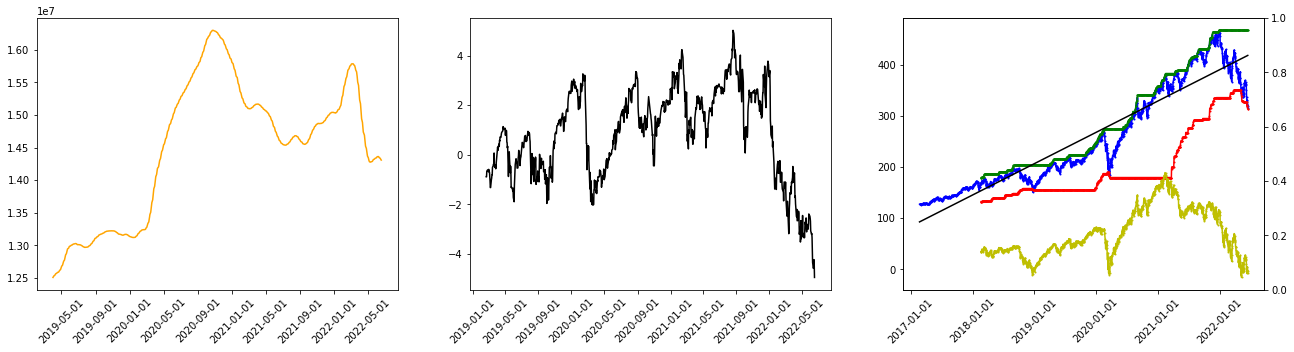

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 1350.1936737743033 1233.3594856412644
test cv mean error, stdev (10 folds): 1427.6804189094346 1267.7724480751428
sell date: 2022-08-26
expected return: 0.03204681022048641
discounted return: 0.0004572642927545001
quarter return: 1.0429556981356594


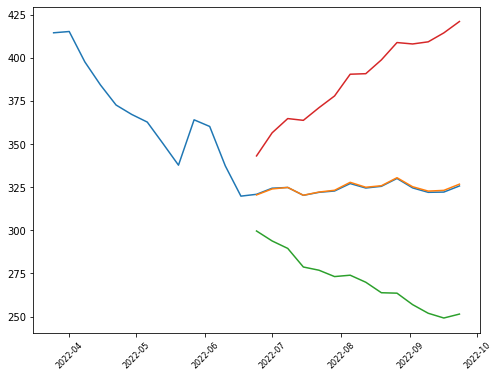

['options', ('2022-08-19',)]
symbol: EQT
sector: Energy
Index: SP400
vol_30d_2yr: 138427084.1796875
Sector 1YMF: -6.420003890991211
1YMF: -6.420003890991211
risk trend factor: -0.4065866699651676
         beta currentRatio debtToEquity dividendRate dividendYield  \
EQT  0.947822        0.398       61.543          0.5         0.013   

          ebitda ebitdaMargins forwardPE freeCashflow grossMargins  \
EQT  -1089323008      -0.13465  5.732057   2408109568        0.734   

    grossProfits heldPercentInstitutions       industry    marketCap  \
EQT   4672261000                 0.96148  Oil & Gas E&P  13281123328   

    operatingCashflow operatingMargins pegRatio priceToBook  \
EQT        2283751936          -0.3565     0.23    1.619867   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
EQT                     1.641695      -0.32564      0.162       -0.09046   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
EQT        -0.3018 

Adj Close    21dBOLD   21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-17  35.939999  37.757538  45.406984  53.05643  40.584762  5.367299   

            90d_lower 90d_upper  
2022-06-17  29.850164  51.31936

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
EQT      1.286201  35.939999  138427084.179688  0.637252  0.584446  0.494719

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


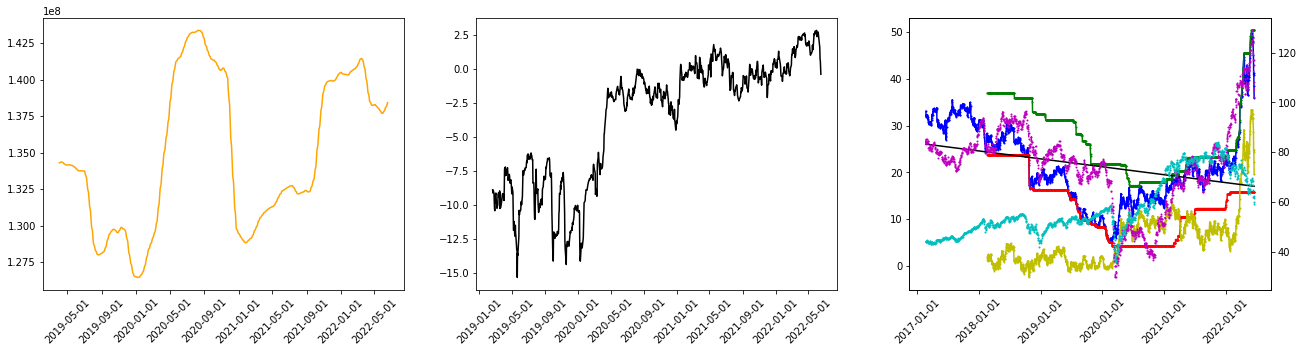

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 30.031748498712673 49.883308592647104
test cv mean error, stdev (10 folds): 32.888753274726675 51.45281027092462
sell date: 2022-09-23
expected return: 0.2819765483492764
discounted return: 0.0025641381368297633
quarter return: 1.265666402159083


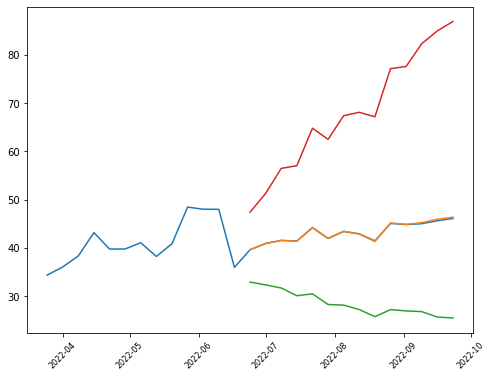

['options', ('2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          10.21
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.64
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             37.38
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticides                          

Adj Close    21dBOLD   21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-17  86.120003  88.433461  96.553809  104.674158  88.917204  6.448671   

            90d_lower   90d_upper  
2022-06-17  76.019861  101.814547

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
XOM      1.153813  86.120003  552640281.25  0.738786  0.784328  0.530974

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


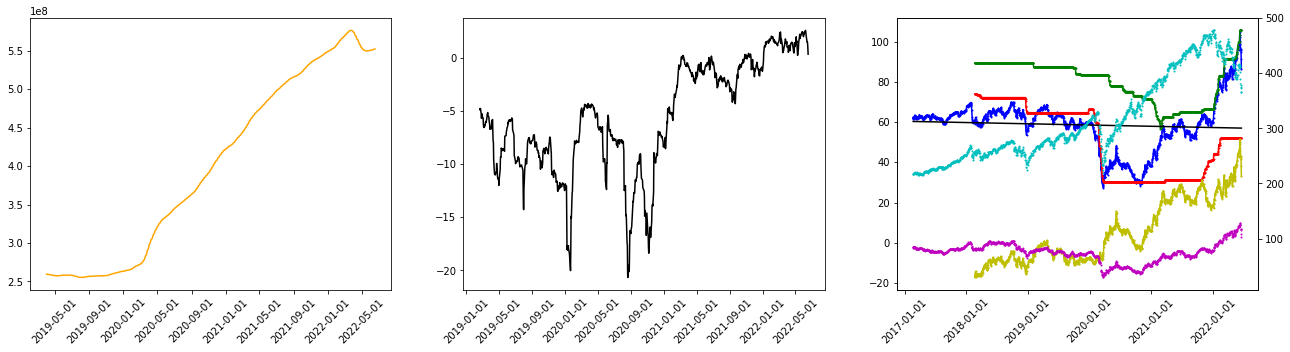

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 135.34504691132688 164.19152746973367
test cv mean error, stdev (10 folds): 148.35327441618784 166.71349570784093
sell date: 2022-09-23
expected return: 0.10644560071069155
discounted return: 0.0010433554212150309
quarter return: 1.1006915437325049


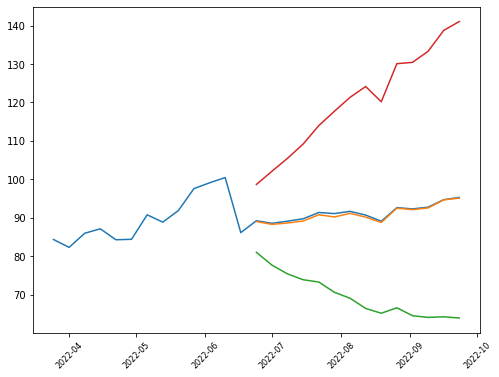

['options', ('2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.82
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.14
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                             36.46
highestControversy                       3
esgPerformance                    OUT_PERF
coal                                 False
pesticid

Adj Close    21dBOLD 21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     58.02  63.067854    72.56  82.052146  65.759365  6.444488   

            90d_lower  90d_upper  
2022-06-17  52.870389  78.648341

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
DVN      1.104104    58.02  237878397.65625  0.701688  0.885466  0.540317

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


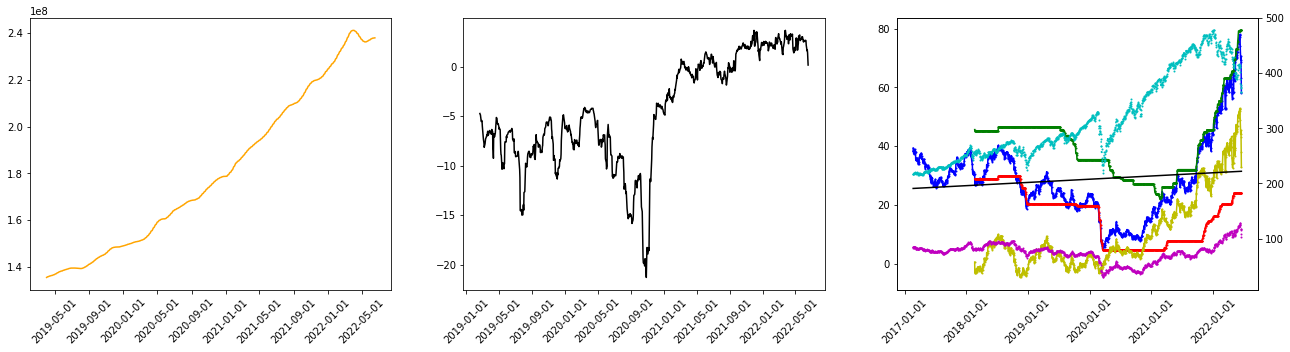

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 68.71417491418524 62.179757983284226
test cv mean error, stdev (10 folds): 74.83646365335838 61.97296167776151
sell date: 2022-09-23
expected return: 0.1808220391019067
discounted return: 0.0017149827102662663
quarter return: 1.1707484793447243


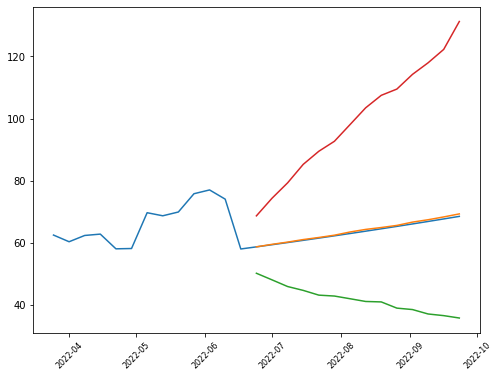

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   7.636000e+09  8.206000e+09  8.189000e+09   
Total Liab                        1.162600e+10  1.199600e+10  1.153000e+10   
Total Stockholder Equity          9.262000e+09  8.924000e+09  8.399000e+09   
Minority Interest                 1.370000e+08  1.370000e+08  1.360000e+08   
Other Current Liab                2.545000e+09  2.940000e+09  2.554000e+09   
Total Assets                      2.102500e+10  2.105700e+10  2.006500e+10   
Common Stock                      6.600000e+07  6.800000e+07  6.800000e+07   
Other Current Assets              5.240000e+08  4.860000e+08  5.030000e+08   
Retained Earnings                 1.692000e+09  7.500000e+08  2.430000e+08   
Other Liab                        1.805000e+09  1.743000e+09  1.698000e+09   
Good Will                         7.530000e+08  7.530000e+08  7.530000e+08   
Treasury Stock                   -1.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     24.15  25.128986  29.471905  33.814823  26.957624  2.372893   

            90d_lower 90d_upper  
2022-06-17  22.211838  31.70341

volume_factor latest_p       vol_30d_2yr   pct_2yr      adf    hurst
MRO      1.000459    24.15  490057840.234375  0.691969  0.80545  0.53536

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


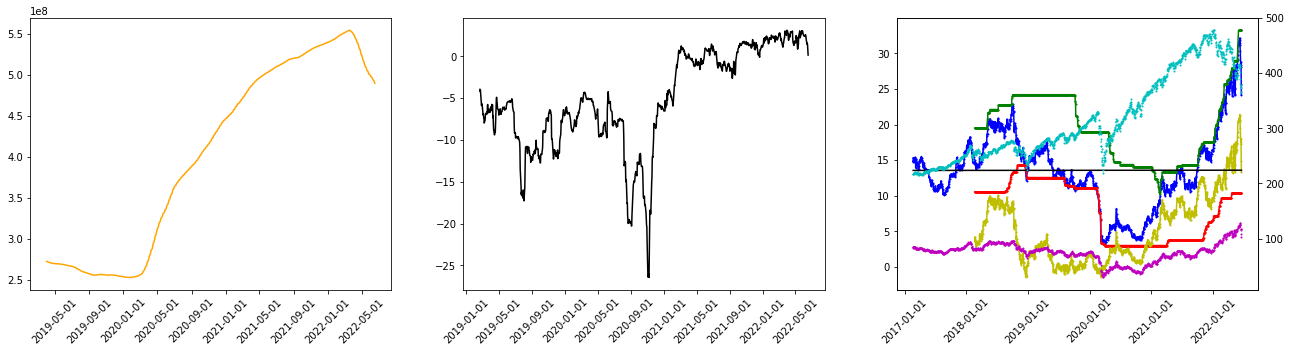

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 12.692432412799683 12.658305738761067
test cv mean error, stdev (10 folds): 13.816439255518134 12.742004600042609
sell date: 2022-09-16
expected return: 0.2363344888271702
discounted return: 0.0023600131734760055
quarter return: 1.2421769061535124


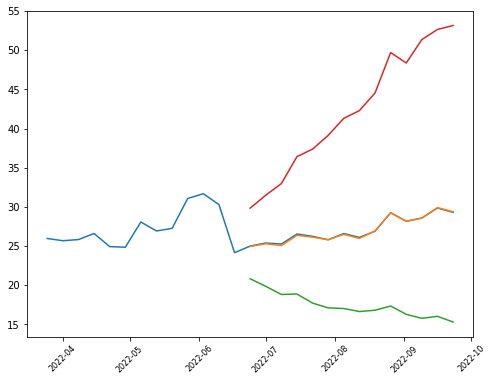

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
Total Current Liabilities  1.637000e+09  1.676000

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  111.669998  116.00035  133.675556  151.350762  125.214127   

             90dSDev   90d_lower   90d_upper  
2022-06-17  8.653608  107.906911  142.521343

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
EOG      0.966433  111.669998  97142371.875  0.688961  0.584303  0.478009

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


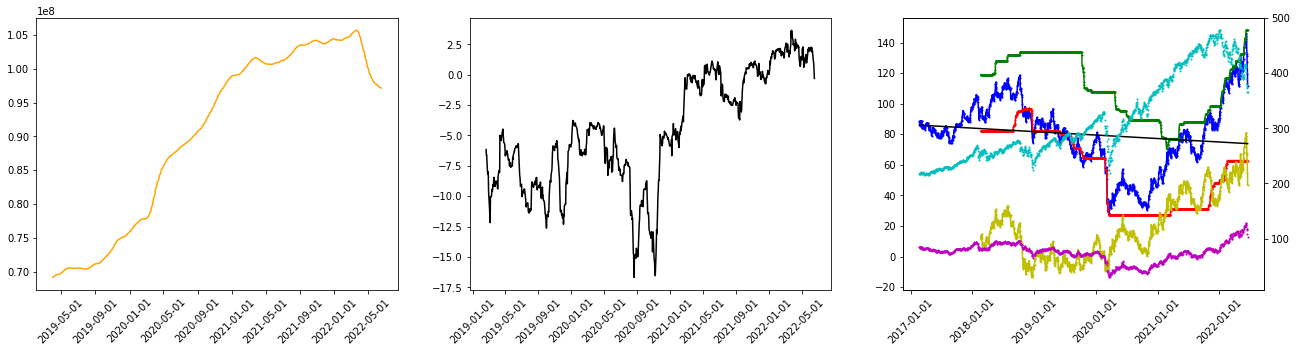

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 263.5076372347407 194.33679723420101
test cv mean error, stdev (10 folds): 286.67242832517366 188.78777840262532
sell date: 2022-06-24
expected return: -0.0019421629372958472
discounted return: -0.00032395607843405116
quarter return: 0.9706311122715182


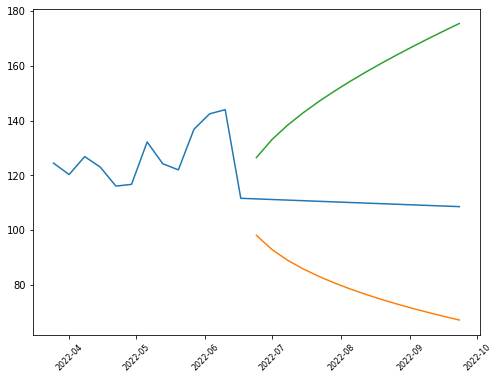

['options', ('2022-07-15', '2023-01-20', '2024-01-19', '2026-03-20')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.13
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.73
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             36.25
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticid

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  102.870003  107.522864  120.951428  134.379992  113.081428   

            90dSDev  90d_lower   90d_upper  
2022-06-17  7.84924  97.382949  128.779908

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
HES      1.067832  102.870003  48039294.53125  0.704306  0.762574  0.442601

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


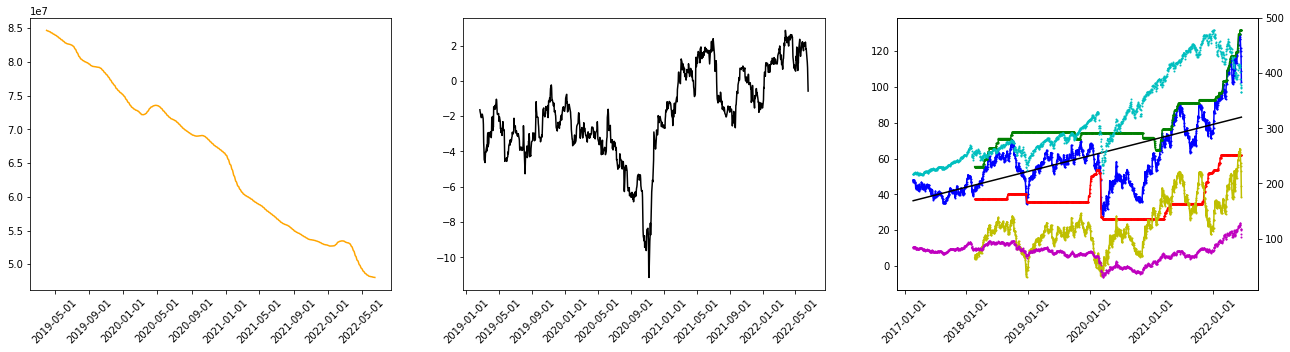

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 184.05307306760244 131.95905894594807
test cv mean error, stdev (10 folds): 199.07107422922346 129.12625755788267
sell date: 2022-09-16
expected return: 0.18915707425317946
discounted return: 0.001926795168458062
quarter return: 1.1937440132563562


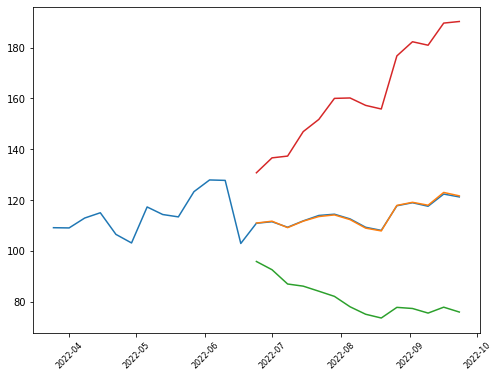

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Total Liab                        1.275000e+10  1.348900e+10  1.323400e+10   
Total Stockholder Equity          6.308000e+09  6.300000e+09  5.609000e+09   
Minority Interest                 7.400000e+08  7.260000e+08  6.470000e+08   
Other Current Liab                2.190000e+09  1.193000e+09  9.330000e+08   
Total Assets                      1.979800e+10  2.051500e+10  1.949000e+10   
Common Stock                      7.074000e+09  3.100000e+08  3.100000e+08   
Other Current Assets              1.896000e+09  1.990000e+08  1.180000e+08   
Other Liab                        1.937000e+09  1.890000e+09  1.877000e+09   
Treasury Stock                   -7.660000e+08 -4.060000e+08 -7.960000e+08   
Other Assets                      1.560000e+09  1.129000e+09  7.660000e+08   
Cash                              1.370000e+09  2.713000e+09  2.419000e+09   
Total Current Liabilities         2.

Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-17  46.150002  47.268535  52.341873  57.415211  46.69127  6.413974   

            90d_lower  90d_upper  
2022-06-17  33.863321  59.519218

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
CEIX      1.548727  46.150002  10292389.84375  0.762563  0.855686  0.521917

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


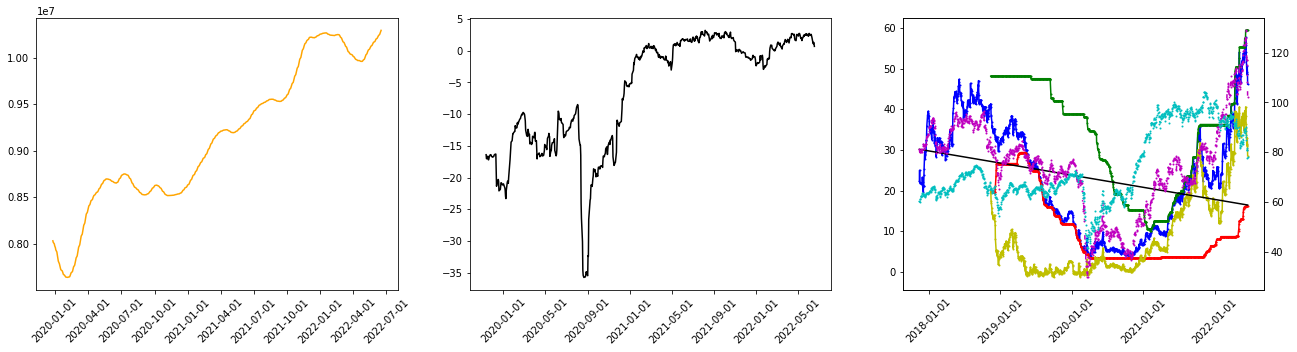

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 36.22631655233729 60.30280617523618
test cv mean error, stdev (10 folds): 36.226316557030934 60.30280617250171
sell date: 2022-09-16
expected return: 0.9213137330039602
discounted return: 0.007282043705804542
quarter return: 1.9493977978896335


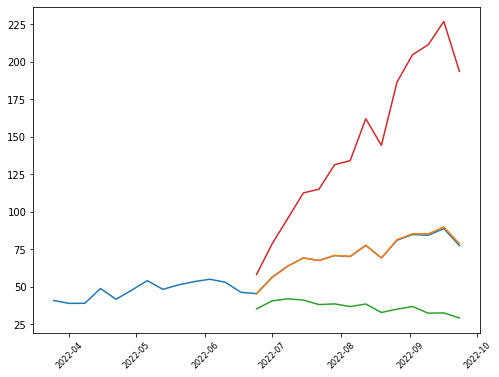

['options', ('2022-08-19',)]
symbol: SM
sector: Energy
Index: SP600
vol_30d_2yr: 85332599.609375
Sector 1YMF: 6.969999313354492
1YMF: 6.969999313354492
risk trend factor: 0.3050327621527311
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
SM  5.488235        0.717       93.916         0.02        0.0006  1315937024   

   ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
SM       0.45427  8.413136    570353344       0.8671   2136878000   

   heldPercentInstitutions       industry   marketCap operatingCashflow  \
SM                 0.88028  Oil & Gas E&P  4823732224        1396240000   

   operatingMargins payoutRatio pegRatio priceToBook  \
SM          0.18012       0.007     0.12    2.946938   

   priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
SM                      1.66518       0.11608        0.7        0.06264   

   returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
SM        0.1731

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  39.709999  36.543497  46.618254  56.693011  41.080159  5.405133   

            90d_lower  90d_upper  
2022-06-17  30.269893  51.890424

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SM      0.640686  39.709999  85332599.609375  0.715458  0.803847  0.471215

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


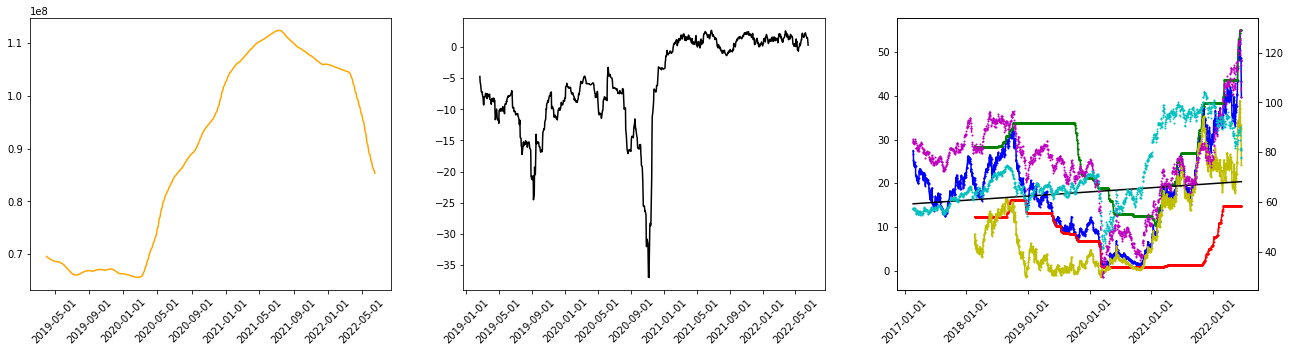

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'add', False]
best inner cv score, sdev (11 folds): 38.18857387753895 45.77804806210083
test cv mean error, stdev (10 folds): 41.847934900877 46.45312720325848
sell date: 2022-09-23
expected return: 0.2763598654292093
discounted return: 0.0025187561453154927
quarter return: 1.2604064198396316


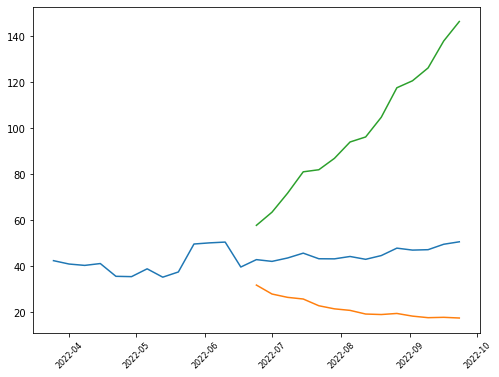

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            1.844478e+09  1.840228e+09  1.838620e+09   
Total Liab                 3.280672e+09  3.170846e+09  3.425061e+09   
Total Stockholder Equity   2.115109e+09  2.063131e+09  1.636899e+09   
Deferred Long Term Liab    2.300000e+06  2.700000e+06  3.100000e+06   
Other Current Liab         5.381270e+08  4.047460e+08  5.520440e+08   
Total Assets               5.395781e+09  5.233977e+09  5.061960e+09   
Common Stock               1.219000e+06  1.219000e+06  1.215000e+06   
Other Current Assets       9.649000e+06  2.409500e+07  2.451400e+07   
Retained Earnings          2.820790e+08  2.345330e+08 -1.903670e+08   
Other Liab                 2.415590e+08  1.809150e+08  2.438640e+08   
Treasury Stock            -1.266700e+07 -1.284900e+07 -1.256900e+07   
Other Assets               5.397300e+07  2.576600e+07  6.020700e+07   
Cash                       4.198870e+08  3.327160

Adj Close    21dBOLD   21dMA-TP  21dBOLU     90dSMA  90dSDev  \
2022-06-17  26.290001  26.463464  32.556032  38.6486  31.029206  2.69788   

            90d_lower  90d_upper  
2022-06-17  25.633446  36.424967

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
RRC      0.930726  26.290001  120549255.664062  0.655439  0.472816  0.488191

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


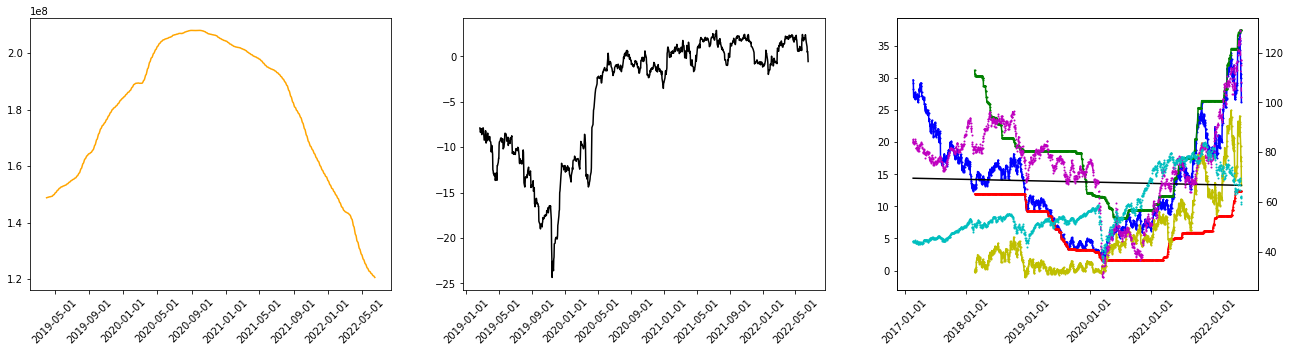

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'add', False]
best inner cv score, sdev (11 folds): 11.350390154837784 13.920119254206307
test cv mean error, stdev (10 folds): 12.432072855646293 14.151900225241045
sell date: 2022-06-24
expected return: -0.0001485350946100342
discounted return: -2.4757381370865694e-05
quarter return: 0.9977248847256419


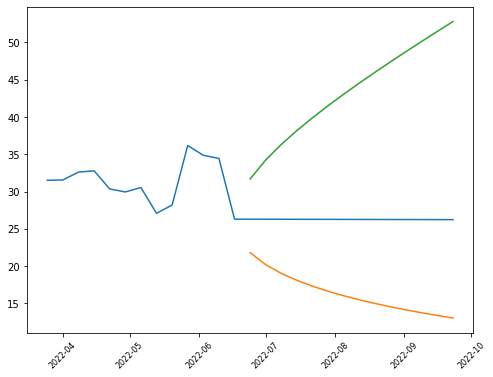

['options', ('2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           None
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       None
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             33.07
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides                          

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  33.639999  33.453331  40.601905  47.750479  39.679365  3.354359   

            90d_lower  90d_upper  
2022-06-17  32.970646  46.388084

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MUR      0.622051  33.639999  64239713.28125  0.686775  0.505866  0.448868

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


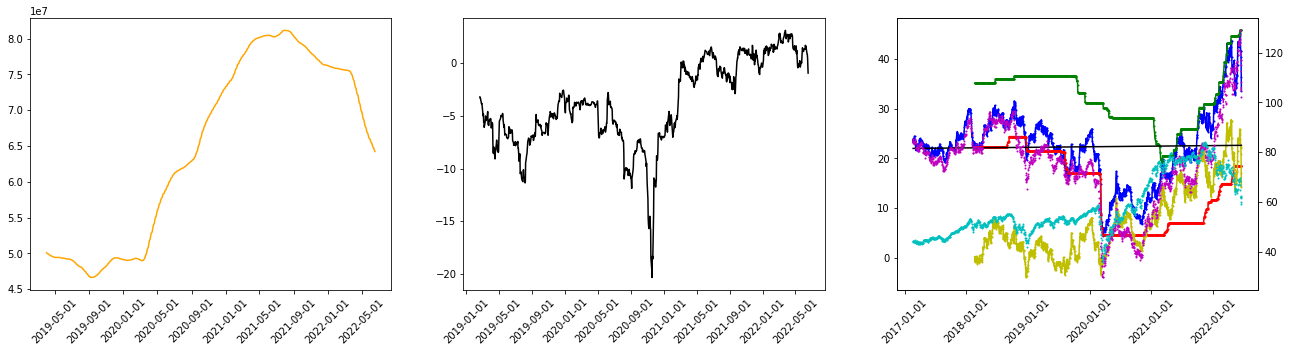

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 31.132739068612207 28.323498804672614
test cv mean error, stdev (10 folds): 33.25936023525206 28.8564636121606
sell date: 2022-09-23
expected return: 0.22154868737901595
discounted return: 0.0020652169444099755
quarter return: 1.2090126478895236


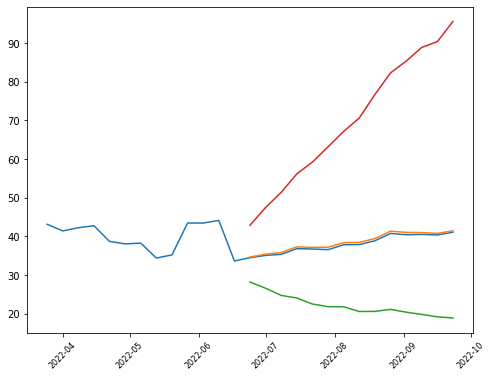

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   9.266980e+08  9.212270e+08  9.151810e+08   
Total Liab                        5.984144e+09  6.216909e+09  6.562362e+09   
Total Stockholder Equity          4.157311e+09  3.949508e+09  3.880600e+09   
Minority Interest                 1.634850e+08  1.644390e+08  1.612280e+08   
Deferred Long Term Liab           2.373800e+07  2.710100e+07  2.964500e+07   
Other Current Liab                1.542410e+08  1.803500e+07  1.917600e+07   
Total Assets                      1.030494e+10  1.033086e+10  1.060419e+10   
Common Stock                      1.951010e+08  1.951010e+08  1.951010e+08   
Other Current Assets              1.973300e+07  4.098700e+07  4.082100e+07   
Retained Earnings                 5.218670e+09  5.069578e+09  4.980428e+09   
Other Liab                        1.593242e+09  1.687479e+09  1.699512e+09   
Treasury Stock                   -2.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  51.200001  48.705794  59.342064  69.978334  55.003573  5.257912   

            90d_lower  90d_upper  
2022-06-17  44.487749  65.519397

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MTDR      0.702256  51.200001  48684538.476562  0.730363  0.889052  0.461003

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


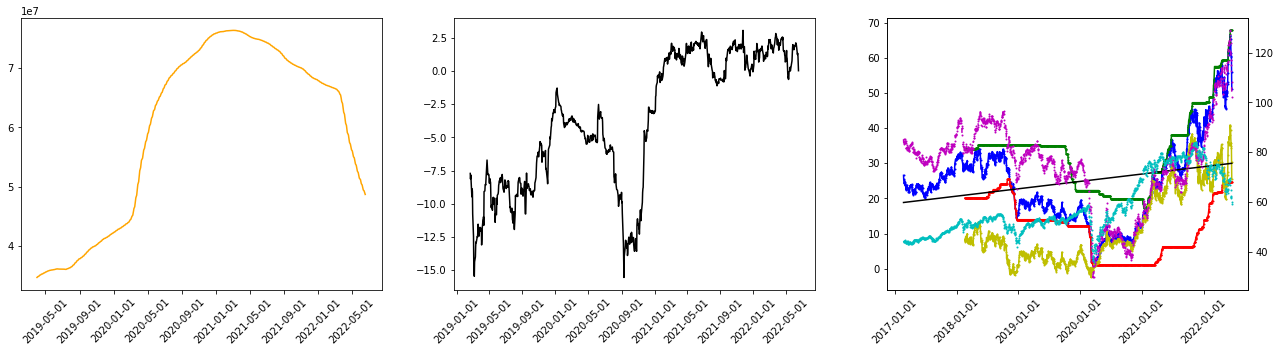

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', False]
best inner cv score, sdev (11 folds): 50.80379827326996 41.06477770485787
test cv mean error, stdev (10 folds): 55.70621311094228 39.88204201220304
sell date: 2022-09-23
expected return: 0.4505019270375954
discounted return: 0.0038414797766888054
quarter return: 1.4229597770944917


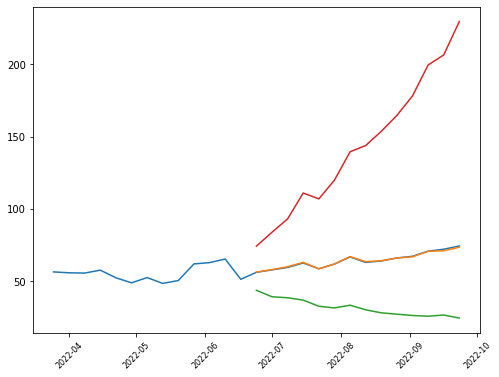

['options', ('2022-07-15', '2023-01-20')]
symbol: PXD
sector: Energy
Index: SP500
vol_30d_2yr: 47391610.9375
Sector 1YMF: -50.03999328613281
1YMF: -50.03999328613281
risk trend factor: -0.727748651596503
         beta currentRatio debtToEquity dividendRate dividendYield  \
PXD  1.535843        1.541       25.456        12.34        0.0556   

         ebitda ebitdaMargins forwardPE freeCashflow grossMargins  \
PXD  9187000320       0.43846  7.828098   2404124928      0.53944   

    grossProfits heldPercentInstitutions       industry    marketCap  \
PXD   9392000000                 0.92214  Oil & Gas E&P  53659250688   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
PXD        8265999872          0.31175      0.3288     0.46     2.26717   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PXD                     2.560934        0.2003      1.404        0.12148   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOuts

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  221.770004  243.334843  270.065238  296.795633  256.810952   

              90dSDev   90d_lower   90d_upper  
2022-06-17  15.318142  226.174668  287.447237

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
PXD      1.317982  221.770004  47391610.9375  0.685246  0.678534  0.490016

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


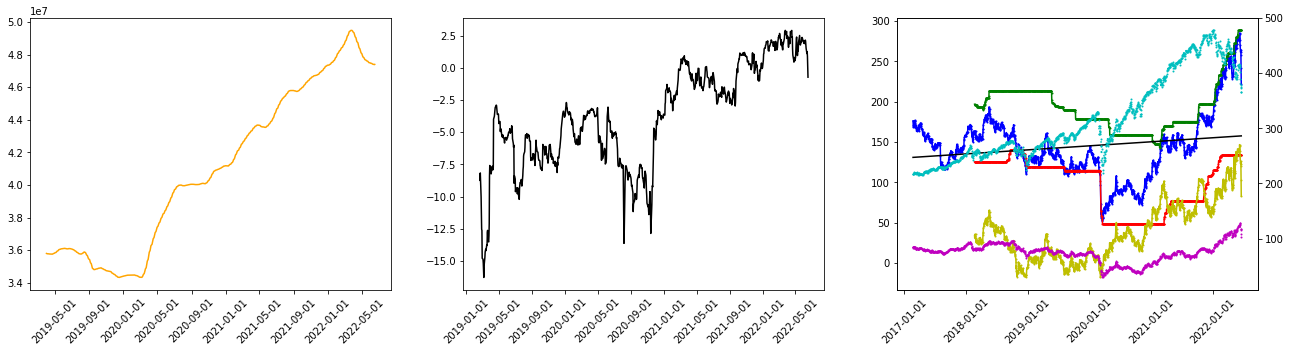

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 945.2115858493137 912.1408616277421
test cv mean error, stdev (10 folds): 1035.233622083089 908.8770046115551
sell date: 2022-08-26
expected return: 0.08911694869070397
discounted return: 0.0012379718739679024
quarter return: 1.1205537380651147


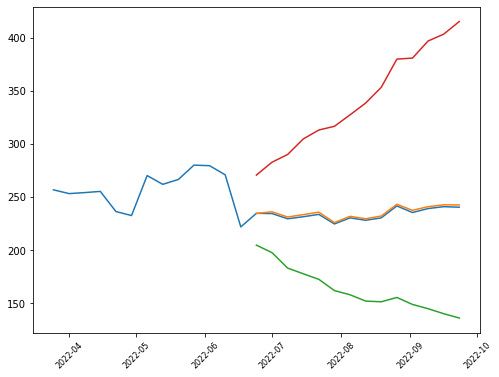

['options', ('2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.97
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                        9.1
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             36.53
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticides                          

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     55.68  56.839295  65.607143  74.374991  61.382222  4.693201   

            90d_lower  90d_upper  
2022-06-17  51.995819  70.768625

volume_factor latest_p       vol_30d_2yr  pct_2yr       adf     hurst
OXY      1.190976    55.68  498984476.953125  0.71978  0.690434  0.542013

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


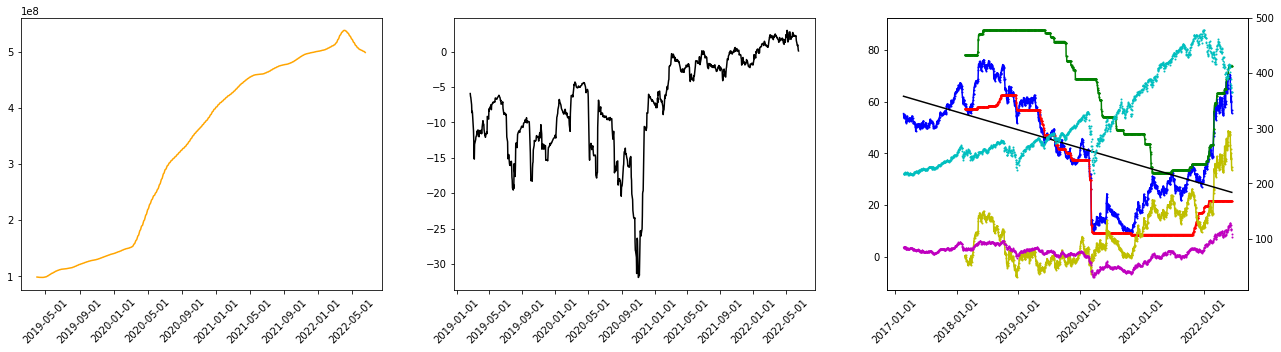

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'add', True]
best inner cv score, sdev (11 folds): 67.21993334657081 59.738870929562374
test cv mean error, stdev (10 folds): 72.47517049631047 60.181502548940344
sell date: 2022-09-16
expected return: 0.14665153996186295
discounted return: 0.0015216675711604566
quarter return: 1.15014383992918


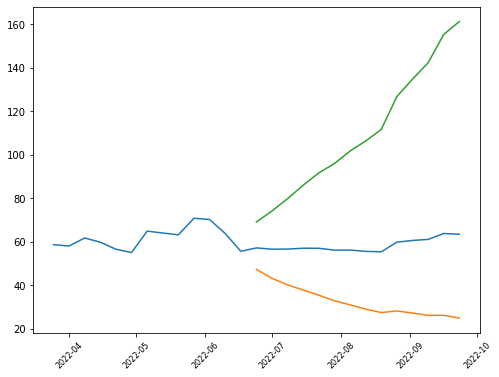

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          12.04
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       6.88
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             43.53
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  64.779999  63.693839  77.329841  90.965843  73.805873  5.730229   

            90d_lower 90d_upper  
2022-06-17  62.345416  85.26633

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PDCE      1.314132  64.779999  24813862.890625  0.689138  0.390825  0.487351

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


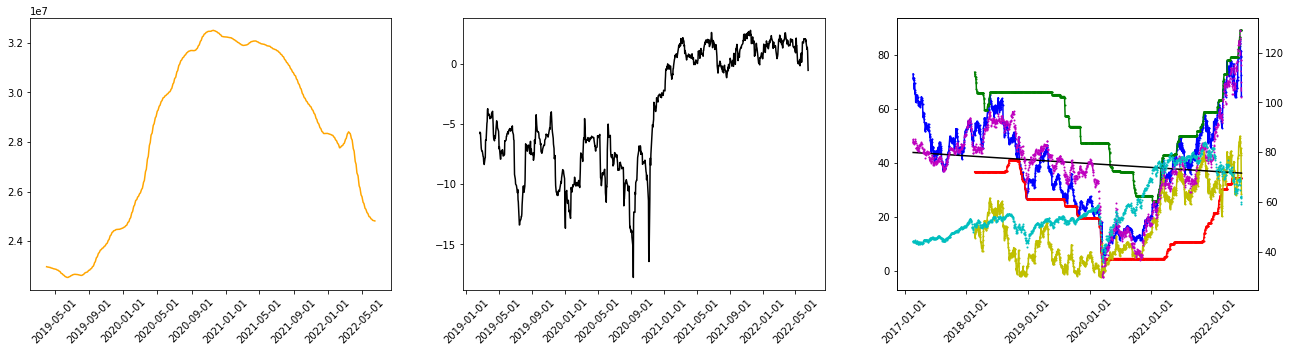

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'add', False]
best inner cv score, sdev (11 folds): 66.24561128265599 64.85907657373443
test cv mean error, stdev (10 folds): 70.97253189396953 66.19371423029085
sell date: 2022-08-26
expected return: 0.2620658318403486
discounted return: 0.0033788829531142817
quarter return: 1.3638795329913624


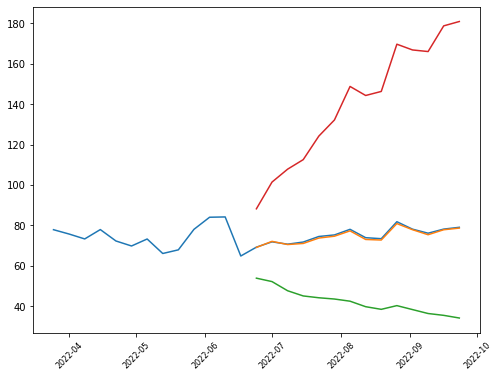

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            3.161941e+09  3.267261e+09  3.333168e+09   
Total Liab                 2.426419e+09  2.823041e+09  2.869083e+09   
Total Stockholder Equity   2.910247e+09  2.544224e+09  2.464906e+09   
Deferred Long Term Liab    1.690000e+07  5.600000e+06  6.400000e+06   
Other Current Liab         6.228770e+08  7.500000e+08  6.521060e+08   
Total Assets               5.336666e+09  5.367265e+09  5.333989e+09   
Common Stock               9.650000e+05  9.740000e+05  9.890000e+05   
Other Current Assets       1.790900e+07  7.559000e+06  5.146000e+06   
Retained Earnings         -2.499540e+08 -7.230170e+08 -8.683380e+08   
Other Liab                 5.579650e+08  5.186080e+08  4.555700e+08   
Treasury Stock            -2.705000e+06 -9.940000e+05 -9.130000e+05   
Other Assets               5.559800e+07  4.755700e+07  4.764500e+07   
Cash                       3.382900e+07  9.992200

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  65.440002  66.196732  71.468095  76.739458  70.233492  2.539221   

            90d_lower  90d_upper  
2022-06-17  65.155049  75.311934

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
NFG       1.09896  65.440002  10051408.984375  0.723622  0.865522  0.460844

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


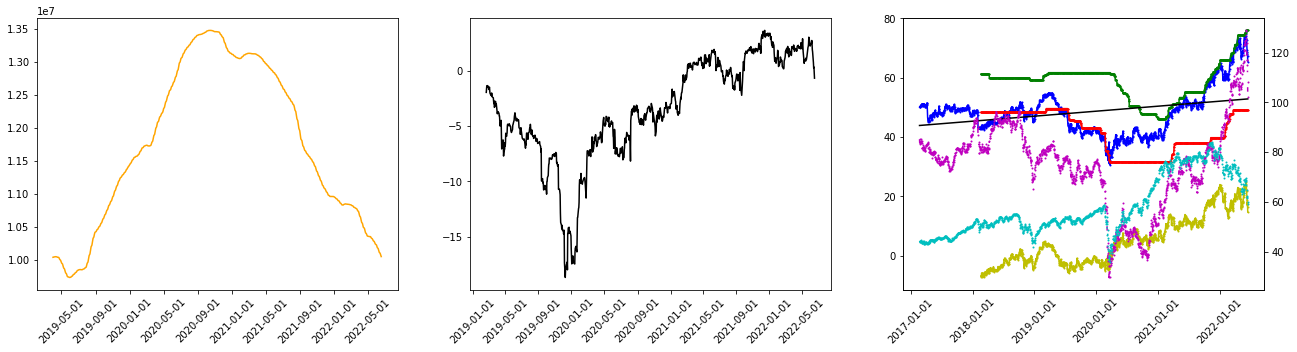

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', None]
best inner cv score, sdev (11 folds): 18.324747184742776 15.305693066945635
test cv mean error, stdev (10 folds): 19.906571504281303 15.171302614962713
sell date: 2022-08-05
expected return: 0.09109436685121705
discounted return: 0.0018179254024808245
quarter return: 1.1818692529860817


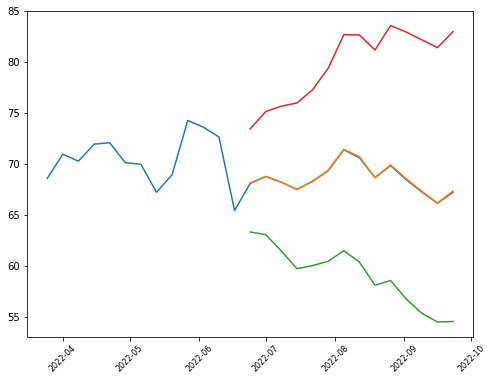

['options', ('2022-07-15',)]
symbol: FANG
sector: Energy
Index: SP500
vol_30d_2yr: 60333589.6484375
Sector 1YMF: -21.420005798339844
1YMF: -21.420005798339844
risk trend factor: -0.5018744567990084
          beta currentRatio debtToEquity dividendRate dividendYield  \
FANG  2.181941         0.72       42.218          2.8        0.0229   

     earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
FANG          2.278  5171999744       0.67999  5.241749    958625024   

     grossMargins grossProfits heldPercentInstitutions       industry  \
FANG      0.87707   5577000000                 0.91762  Oil & Gas E&P   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
FANG  21473144832        4572000256           0.5071      0.1272     0.35   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
FANG    1.703891                     2.823185       0.36037      0.656   

     returnOnAssets returnOnEquity revenueGrowth revenuePerShar

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-17  122.290001  125.260628  146.419524  167.57842  139.154444   

             90dSDev  90d_lower   90d_upper  
2022-06-17  9.491267  120.17191  158.136978

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
FANG       1.13222  122.290001  60333589.648438  0.711781  0.579467  0.467129

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -287.8400573730469
Index Volume Factor: 1.1835166983613057
Index Risk Trend Factor: -3.791860877423899


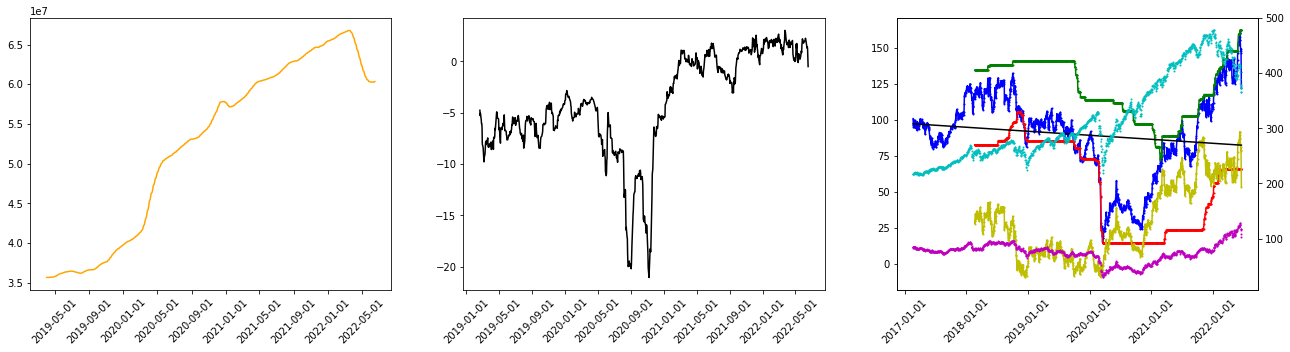

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'add', True]
best inner cv score, sdev (11 folds): 459.0050483558149 368.234703595398
test cv mean error, stdev (10 folds): 499.215977209822 362.45050877841464
sell date: 2022-09-23
expected return: 0.1252357812388129
discounted return: 0.0012171586630722597
quarter return: 1.1184127631338863


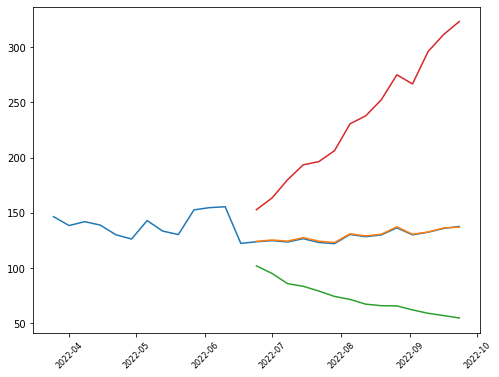

['options', ('2023-01-20', '2024-01-19')]
symbol: TWI
sector: Industrials
Index: SP600
vol_30d_2yr: 10530212.5
Sector 1YMF: 6.0800018310546875
1YMF: 6.0800018310546875
risk trend factor: 0.9310876079145333
         beta currentRatio debtToEquity earningsGrowth     ebitda  \
TWI  2.412885        1.853      219.119          0.682  163579008   

    ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
TWI       0.08464   8.09589    -24455124      0.13457    227051000   

    heldPercentInstitutions                             industry   marketCap  \
TWI                 0.77816  Farm & Heavy Construction Machinery  1110906752   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
TWI           8171000          0.06043           0     0.38    4.470499   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
TWI                     0.574797       0.03101      0.829        0.06237   

    returnOnEquity revenueGrowth revenuePerShare 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17     17.52  16.247353  18.072381  19.897408  15.954921  1.924943   

            90d_lower  90d_upper  
2022-06-17  12.105034  19.804807

volume_factor latest_p vol_30d_2yr   pct_2yr       adf     hurst
TWI      1.389288    17.52  10530212.5  0.876816  0.791457  0.500704

Sector 1YMF: -141.5800018310547
Sector Volume Factor: 0.8696853533786545
Sector Risk Trend Factor: -4.514668337867341
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


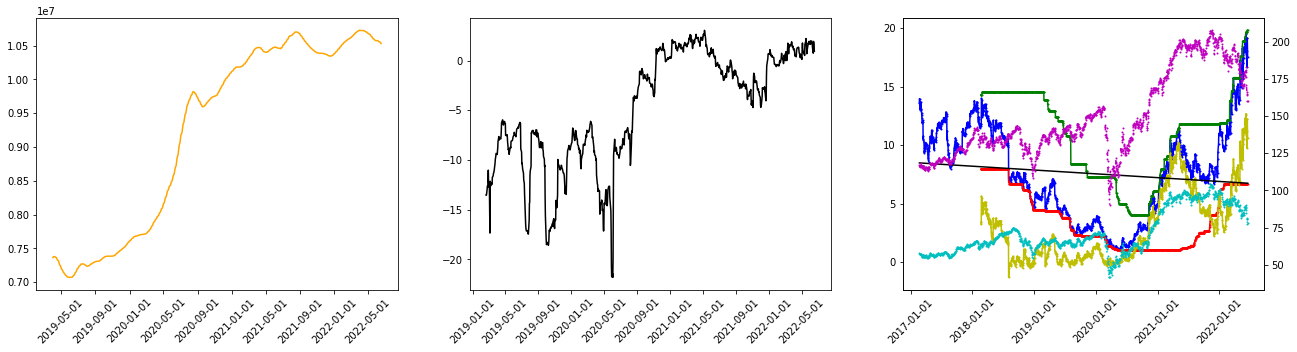

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'add', True]
best inner cv score, sdev (11 folds): 4.43977579592289 6.248313486042797
test cv mean error, stdev (10 folds): 4.868334984924159 6.397286247099476
sell date: 2022-09-23
expected return: 0.042219664930082564
discounted return: 0.00042640771054158755
quarter return: 1.0400004520992914


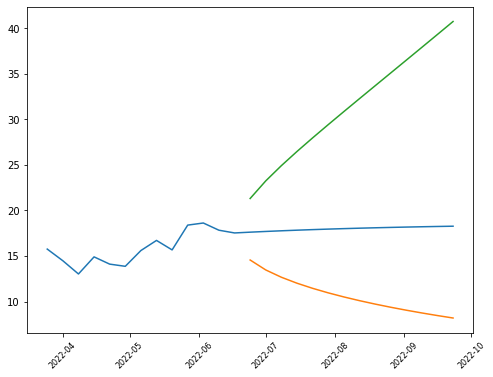

['options', ('2022-07-15',)]
symbol: PBF
sector: Energy
Index: SP600
vol_30d_2yr: 92668774.0234375
Sector 1YMF: 17.619998931884766
1YMF: 17.619998931884766
risk trend factor: 0.8876574451557954
         beta currentRatio debtToEquity     ebitda ebitdaMargins  forwardPE  \
PBF  2.259981        1.254      197.914  690400000       0.02194  11.930909   

    freeCashflow grossMargins grossProfits heldPercentInstitutions  \
PBF    284750016       0.0362    671100000                 0.80139   

                           industry   marketCap operatingCashflow  \
PBF  Oil & Gas Refining & Marketing  3964366848         803299968   

    operatingMargins payoutRatio pegRatio priceToBook  \
PBF           0.0135           0    -0.18    2.070946   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PBF                     0.125972       0.00798      0.629        0.02192   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
PBF        0.14223   

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-17     32.98  27.175062  35.668889  44.162716  29.964286  5.34115   

            90d_lower  90d_upper  
2022-06-17  19.281986  40.646585

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PBF      0.835417    32.98  92668774.023438  0.721917  0.581704  0.554972

Sector 1YMF: -3.82000732421875
Sector Volume Factor: 0.8966412344901694
Sector Risk Trend Factor: -0.12330558135216596
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


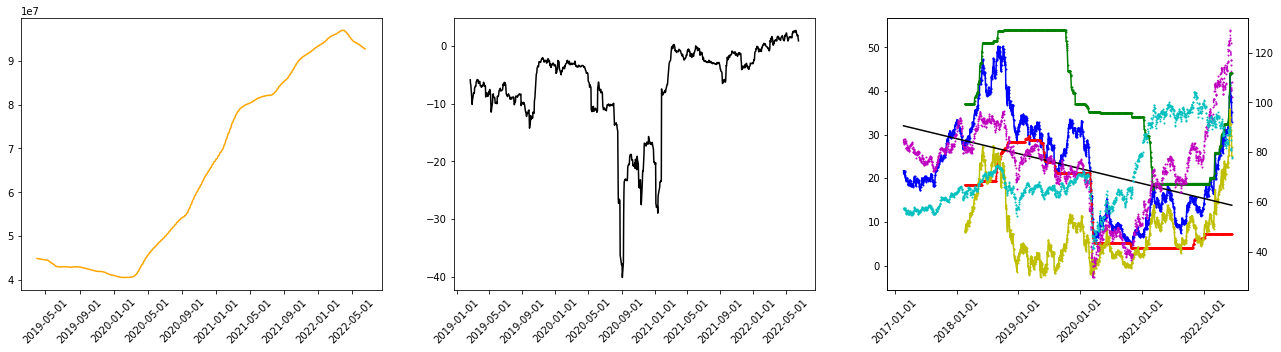

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 32.03876381353625 24.823206438530256
test cv mean error, stdev (10 folds): 30.71500806516274 25.661938522169393
sell date: 2022-09-23
expected return: 0.13271601266179398
discounted return: 0.0012855503530107004
quarter return: 1.125463190872125


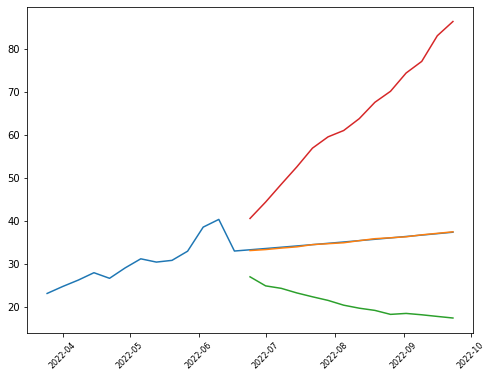

['options', ('2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: MANT
sector: Technology
Index: SP600
vol_30d_2yr: 4428022.265625
Sector 1YMF: 5.6399993896484375
1YMF: 5.6399993896484375
risk trend factor: 0.32063661839633545
          beta currentRatio debtToEquity dividendRate dividendYield  \
MANT  0.737745        1.584       23.665         1.64          0.02   

     earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  \
MANT          -0.07  264191008       0.10344  25.047745     89507376   

     grossMargins grossProfits heldPercentInstitutions              industry  \
MANT      0.14856    379411000                 0.71066  Software—Application   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
MANT  3867116288         212171008          0.07374      0.4669     4.97   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
MANT    2.299301                     1.514167       0.05365      1.462   

     retur

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  94.790001  94.21236  94.956032  95.699705  88.233333  5.546632   

            90d_lower  90d_upper  
2022-06-17  77.140069  99.326598

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MANT      2.782348  94.790001  4428022.265625  0.833671  0.571232  0.363702

Sector 1YMF: -363.4599914550781
Sector Volume Factor: 1.1528457613891094
Sector Risk Trend Factor: -4.954471974241429
Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


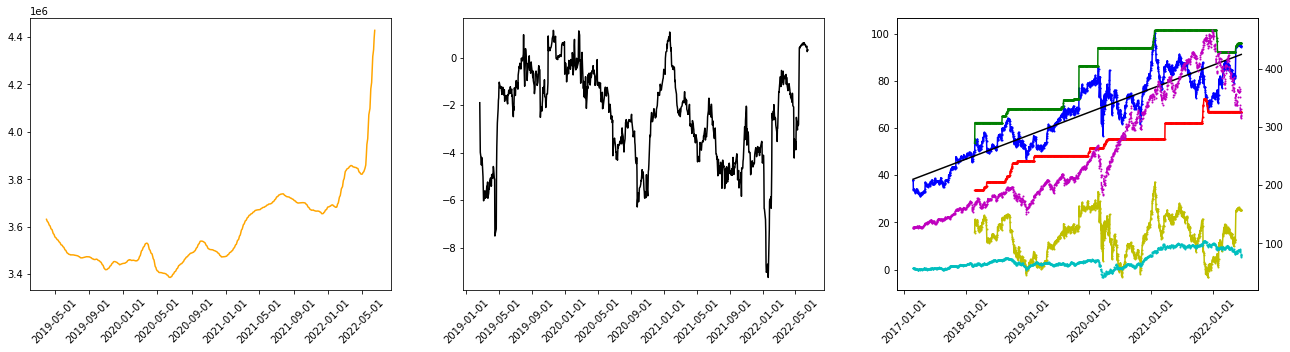

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 79.0823831464889 56.433028995232796
test cv mean error, stdev (10 folds): 75.67081784013739 58.095859417861696
sell date: 2022-08-26
expected return: 0.13211468439122453
discounted return: 0.001799984493789042
quarter return: 1.17992362829449


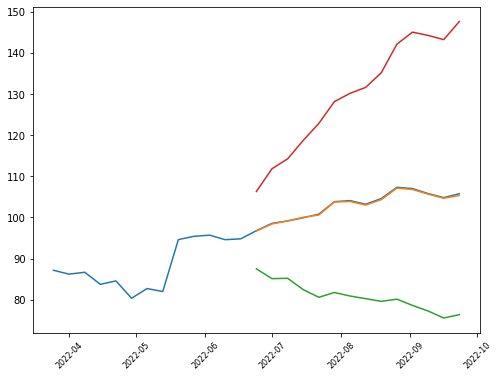

['options', ('2022-08-19',)]
symbol: HRB
sector: Consumer Cyclical
Index: SP400
vol_30d_2yr: 54249330.46875
Sector 1YMF: 9.64000129699707
1YMF: 9.64000129699707
risk trend factor: 0.73141120475963
         beta currentRatio debtToEquity dividendRate dividendYield  \
HRB  0.695099        1.103     5314.905         1.08        0.0327   

    earningsGrowth     ebitda ebitdaMargins forwardPE grossMargins  \
HRB         -0.008  806428032       0.30238  8.967391        0.472   

    grossProfits heldPercentInstitutions           industry   marketCap  \
HRB   1400058000                 0.93136  Personal Services  5266601984   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
HRB          80728000          0.25066      0.3344     0.99   117.43773   

    priceToSalesTrailing12Months profitMargins quickRatio revenueGrowth  \
HRB                      1.97476       0.16063      0.971         0.039   

    revenuePerShare             sector sharesOutstanding shortRatio 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17      33.0  32.411108  34.624444  36.837781  29.692222  4.042801   

           90d_lower  90d_upper  
2022-06-17  21.60662  37.777824

volume_factor latest_p     vol_30d_2yr  pct_2yr       adf     hurst
HRB      0.963511     33.0  54249330.46875  0.83894  0.727369  0.435637

Sector 1YMF: -359.96002197265625
Sector Volume Factor: 1.2928194874233667
Sector Risk Trend Factor: -4.72140697901556
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


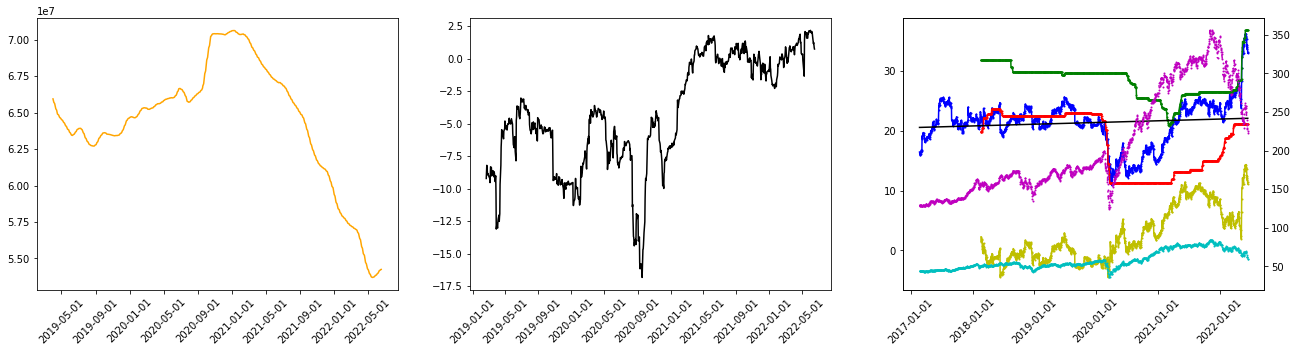

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: [None, 'mul', False]
best inner cv score, sdev (11 folds): 6.864336628672092 6.3615256006982515
test cv mean error, stdev (10 folds): 7.292307789922857 6.519291105037877
sell date: 2022-09-23
expected return: 0.15781104020008568
discounted return: 0.0015117723827935414
quarter return: 1.1490988587232984


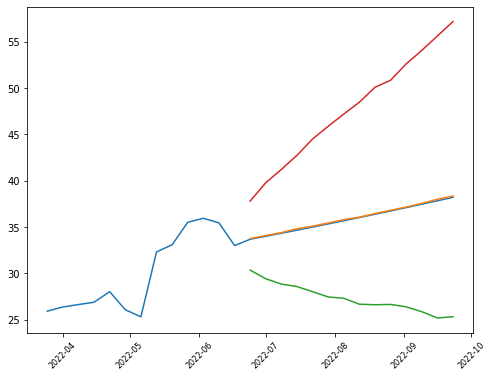

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: VDC
sector: error
sector: Consumer Defensive
Index: nan
vol_30d_2yr: 3264449.609375
Sector 1YMF: -74.80001831054688
1YMF: -74.80001831054688
risk trend factor: -2.283970024749523
      totalAssets
VDC  8.239956e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-17  177.059998  176.153403  185.845715  195.538026  194.674128   

             90dSDev   90d_lower   90d_upper  
2022-06-17  7.920194  178.833739  210.514517

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
VDC      1.413592  177.059998  3264449.609375  0.48903  0.752482  0.355797

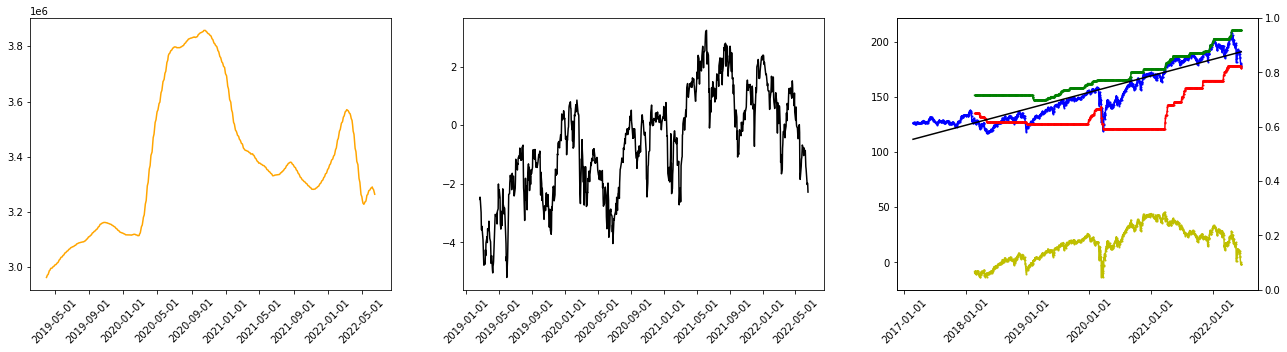

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 191.49791417755577 238.74580523971844
test cv mean error, stdev (10 folds): 195.94534542673026 249.96392674806802
sell date: 2022-08-12
expected return: 0.03199293925203201
discounted return: 0.0005727425949118015
quarter return: 1.0540893669720386


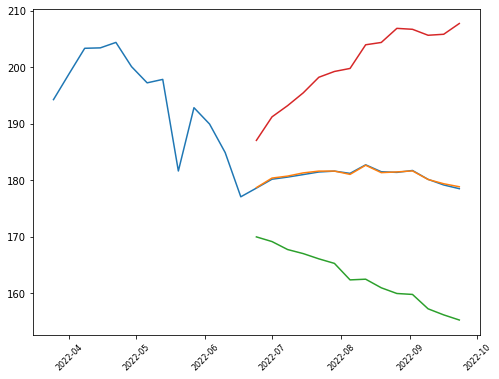

['options', ('2022-07-15',)]
symbol: ACC
sector: Real Estate
Index: SP400
vol_30d_2yr: 27009982.03125
Sector 1YMF: 13.440017700195312
1YMF: 13.440017700195312
risk trend factor: 10.926847725292072
        beta currentRatio debtToEquity dividendRate dividendYield  \
ACC  1.00147        2.184      122.276         1.88         0.029   

    earningsGrowth     ebitda ebitdaMargins forwardPE grossMargins  \
ACC          1.498  466354240       0.47421  98.81539       0.5349   

    grossProfits heldPercentInstitutions          industry   marketCap  \
ACC    498042000                 0.97986  REIT—Residential  8938053632   

    operatingMargins payoutRatio pegRatio priceToBook  \
ACC          0.19318         4.7     1.96    2.993987   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
ACC                     9.088625       0.06005      1.888        0.01582   

    returnOnEquity revenueGrowth revenuePerShare       sector  \
ACC        0.01872         0.176         

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  64.230003  64.240713  64.712222  65.183731  62.082857  3.916774   

            90d_lower  90d_upper  
2022-06-17  54.249309  69.916406

volume_factor   latest_p     vol_30d_2yr  pct_2yr       adf     hurst
ACC      2.134689  64.230003  27009982.03125  0.97101  0.978004  0.420279

Sector 1YMF: -76.09000396728516
Sector Volume Factor: 1.2315342134094496
Sector Risk Trend Factor: -3.053370235265123
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


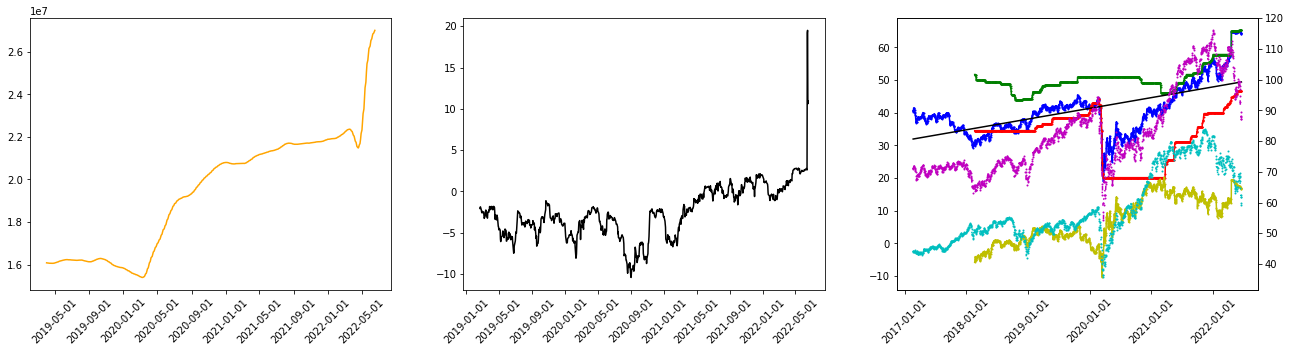

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', False]
best inner cv score, sdev (11 folds): 60.642543509569535 138.4797986966537
test cv mean error, stdev (10 folds): 66.26502219043866 144.03674940822287
sell date: 2022-09-02
expected return: 0.03505054443547022
discounted return: 0.0004533956570731412
quarter return: 1.0425847300311661


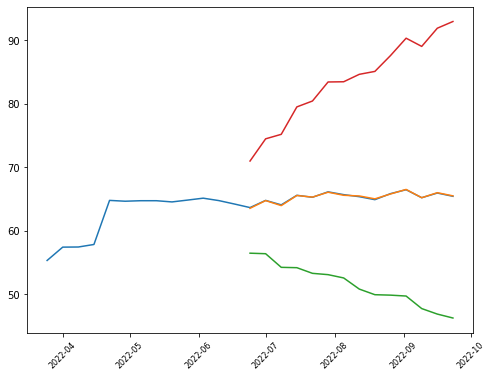

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            4.693018e+09  4.694242e+09  4.538210e+09   
Total Liab                 4.218002e+09  4.273301e+09  4.501487e+09   
Total Stockholder Equity   3.093994e+09  3.117378e+09  2.982993e+09   
Minority Interest          1.842520e+08  1.839070e+08  6.423900e+07   
Deferred Long Term Liab    7.300000e+06  3.450000e+07  2.750000e+07   
Total Assets               7.496248e+09  7.574586e+09  7.548719e+09   
Common Stock               1.393000e+06  1.391000e+06  1.390000e+06   
Other Current Assets       1.698800e+07  1.432600e+07  2.016300e+07   
Other Liab                 1.522020e+08  1.697290e+08  1.850330e+08   
Treasury Stock            -1.600417e+09 -1.578255e+09 -1.556607e+09   
Other Assets               2.143290e+08  1.773490e+08  2.318220e+08   
Cash                       8.765600e+07  1.203510e+08  4.207300e+07   
Total Current Liabilities  5.727700e+07  1.168230

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  40.150002  35.915072  38.024936  40.134801  35.226667  2.439389   

            90d_lower  90d_upper  
2022-06-17  30.347888  40.105445

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
GO      1.191531  40.150002  21744971.289062  0.687007  0.173605  0.403873

Sector 1YMF: -74.80001831054688
Sector Volume Factor: 1.4135920452708397
Sector Risk Trend Factor: -2.283970024749523
Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


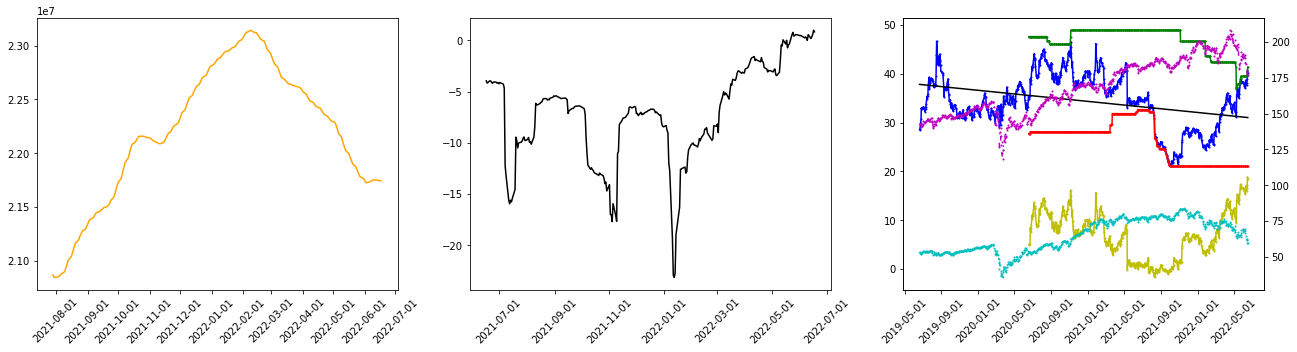

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 23.788531770555906 17.286788080066042
test cv mean error, stdev (10 folds): 23.78853331644342 17.286791788688287
sell date: 2022-07-22
expected return: 0.1274470454560351
discounted return: 0.003534343613466495
quarter return: 1.3834582599298348


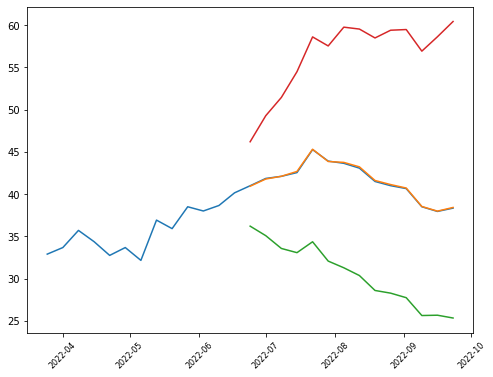

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: TVTY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 10900973.046875
Sector 1YMF: 2.7400035858154297
1YMF: 2.7400035858154297
risk trend factor: 2.3418794362082624
Empty DataFrame
Columns: []
Index: [TVTY]


Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-17  32.130001  31.878985  32.19127  32.503555  31.861111  0.826432   

            90d_lower  90d_upper  
2022-06-17  30.208246  33.513976

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TVTY      1.643789  32.130001  10900973.046875  0.966327  0.518794  0.448871

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


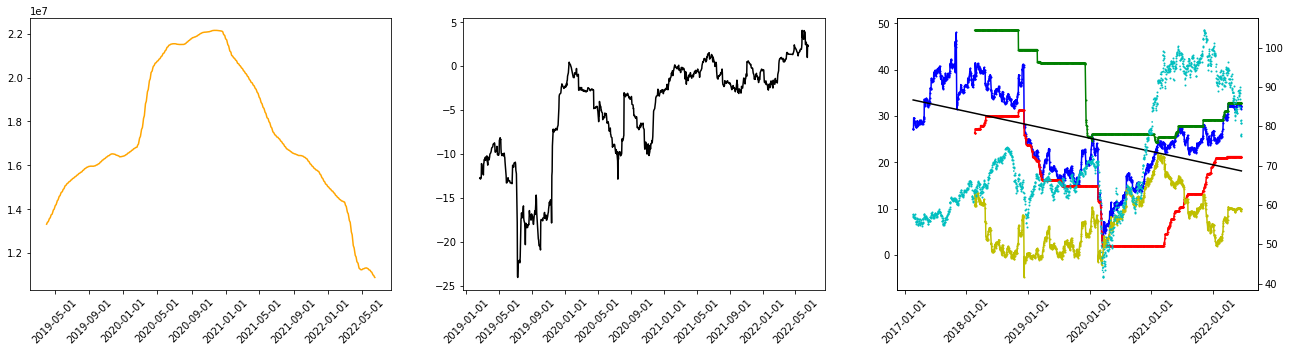

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', 'mul', True]
best inner cv score, sdev (11 folds): 18.832273543039243 14.827822266373204
test cv mean error, stdev (10 folds): 19.958987625493084 15.095907110456098
sell date: 2022-08-05
expected return: 0.05408821482336362
discounted return: 0.0010980220080683
quarter return: 1.1062352736529146


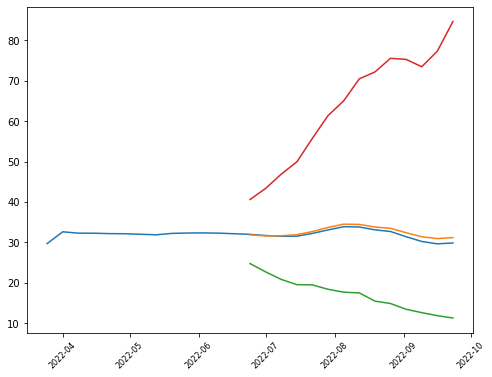

['options', ('2022-08-19',)]
symbol: FCN
sector: error
sector: error
Index: SP400
vol_30d_2yr: 6853053.3203125
Sector 1YMF: 6.7500152587890625
1YMF: 6.7500152587890625
risk trend factor: 0.3590433065465876
Empty DataFrame
Columns: []
Index: [FCN]


Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-17  164.020004  159.077845  165.278412  171.47898  162.282857   

             90dSDev   90d_lower   90d_upper  
2022-06-17  5.027495  152.227867  172.337847

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
FCN      0.694756  164.020004  6853053.320312  0.888589  0.922824  0.404937

Index 1YMF: -69.05999755859375
Index Volume Factor: 0.5765983741853883
Index Risk Trend Factor: -5.134573474205833


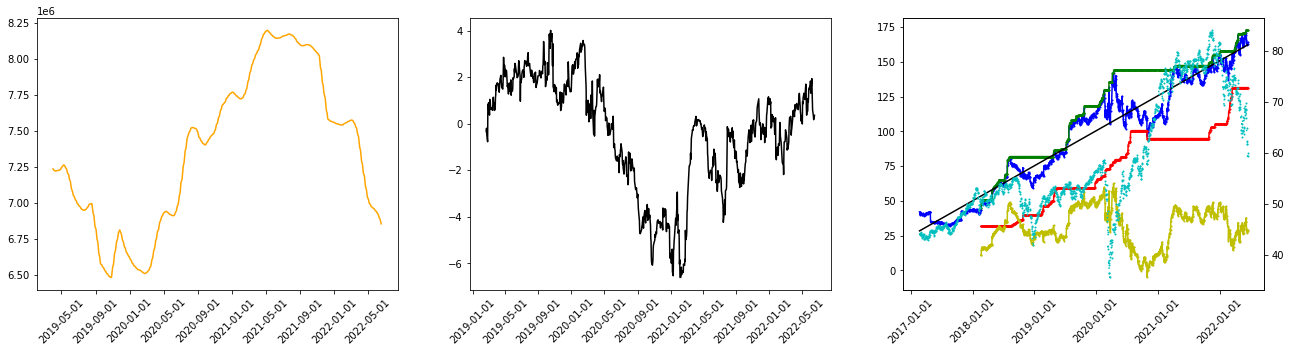

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['mul', 'mul', True]
best inner cv score, sdev (11 folds): 113.70674073030936 46.52872713460469
test cv mean error, stdev (10 folds): 109.63912539319355 46.897916019199755
sell date: 2022-09-02
expected return: 0.13640859726496324
discounted return: 0.001683954898118678
quarter return: 1.1674169282463545


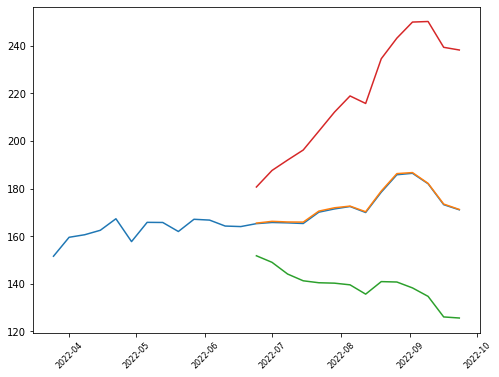

symbol: VIVO
sector: error
sector: error
Index: SP600
vol_30d_2yr: 11730103.3203125
Sector 1YMF: 0.6100006103515625
1YMF: 0.6100006103515625
risk trend factor: 0.10971235052954659
Empty DataFrame
Columns: []
Index: [VIVO]


Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-17      28.5  25.427799  27.012222  28.596646  26.44746  1.162243   

            90d_lower  90d_upper  
2022-06-17  24.122974  28.771947

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VIVO      0.591657     28.5  11730103.320312  0.878325  0.565494  0.431737

Index 1YMF: -77.27001953125
Index Volume Factor: 1.232760496116622
Index Risk Trend Factor: -5.242200185196592


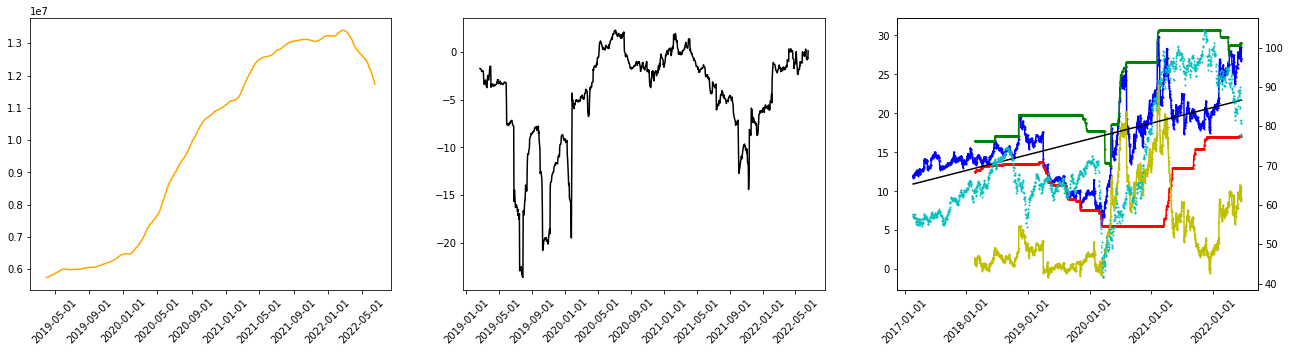

ets next 13 weeks
2022-06-17
2022-06-24
inner cv scores:
best model: ['add', None]
best inner cv score, sdev (11 folds): 13.788280356464544 13.738014778596314
test cv mean error, stdev (10 folds): 15.089252087061718 13.747310761770128
sell date: 2022-09-23
expected return: 0.10807420709324252
discounted return: 0.0010585346980978017
quarter return: 1.1022281100955453


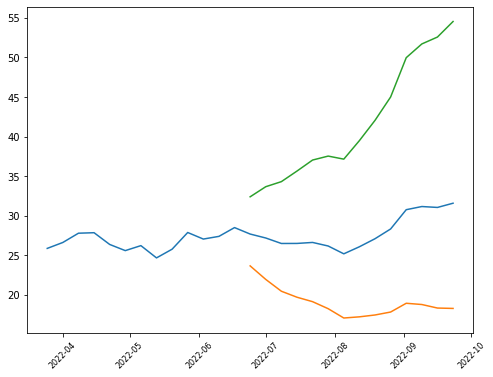

['options', ('2022-07-15',)]


In [58]:
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

client = Client('192.168.3.100:8786')

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
decision_metrics = []

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""

for s in list__:

    #for s in ['CEIX']:
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s]

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("vol_30d_2yr:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    #print("1YMF:",subset['1YMF'].values[-1])
    print("Sector 1YMF:",screener[screener.index==s]['1YMF'][0])
    print("1YMF:",screener.iloc[np.where(screener.index==s)]['1YMF'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)

    mean_revert_flag = False

    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True    

    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(22,5))
    ax1.plot(subset['30d_vol_2yr'],color='orange')
    ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)


    ax1.xaxis.set_major_formatter(date_form)

    #plt.title('30d_vol_2yr')
    ax2.plot(subset['risk_trend_factor'],color='black')
    ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)

    ax2.xaxis.set_major_formatter(date_form)
    #plt.title('risk_trend_factor')

    #fig, ax1 = plt.subplots()   

    ax4 = ax3.twinx()

    if(symbol_sector=='error'):
        pass
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])            
            print("Sector 1YMF:",screener[screener.index==symbol_sector]['1YMF'][0])
            print("Sector Volume Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['volume_factor'][0])
            print("Sector Risk Trend Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['risk_trend_factor'][0])
            ax4.plot(x, (prices[prices['Symbol']==symbol_sector]['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
            #ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            print("Index 1YMF:",screener[screener.index==temp_sm.loc[s]['index_Symbol']]['1YMF'][0])
            print("Index Volume Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['volume_factor'][0])
            print("Index Risk Trend Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['risk_trend_factor'][0])

            ax4.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

    ax3.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

    ax3.plot(x, mymodel, color = 'k')

    #for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
        #labels.append(l)

    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    

    ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)

    ax3.xaxis.set_major_formatter(date_form)
    plt.show()

    print("ets next 13 weeks")

    #take last nyse date and extrapolate weeks from that point
    #starting from next week
    newDates = pd.date_range((subset.index[-1] + dt.timedelta(7)).strftime('%Y-%m-%d'), (subset.index[-1] + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))

    print(subset.index[-1].strftime('%Y-%m-%d'))
    print(newDates[0])
    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()

    cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

    #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
    cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

    outer_results = []

    #sm.tsa.statespace.ExponentialSmoothing
    """
    flags = []
    seasonal_flags1 = ['add','mul',None]

    trend_flags2 = ['add','mul',None]

    damped__trend_flags3 = [True,False]

    for sf in seasonal_flags1:
        for dt_ in trend_flags2:
            if(dt_ is None):          
                for d_ in damped__trend_flags3:
                    flags.append([sf,dt_,d_])
    """

    flags = [['add', 'add', True],\
     ['add', 'add', False],\
     ['add', 'mul', True],\
     ['add', 'mul', False],\
     ['add', None],\
     ['mul', 'add', True],\
     ['mul', 'add', False],\
     ['mul', 'mul', True],\
     ['mul', 'mul', False],\
     ['mul', None],\
     [None, 'add', True],\
     [None, 'add', False],\
     [None, 'mul', True],\
     [None, 'mul', False],\
     [None, None]]

    #print(flags)

    #flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

    rmse_inner_flags = []

    for flag in flags:

        npa = []

        for trainv_ix, test_ix in cv_inner.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,flag])

        future = client.map(evaluate_ets, npa)        

        rmses_inner = []
        #flag_order = []
        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                #this causes errors with [flag,rmse] being passed by evaluate_ets
                rmses_inner.append([np.nan])
            else:
                rmses_inner.append(f.result())

        #I don't want to keep track of flag here
        #flag_order = [r[0] for r in results_rmses].copy()

        rmse_ = [r[1] for r in rmses_inner].copy()
        #print(rmse_)
        #print(flag)
        rmse_inner_flags.append([flag,np.nanmean(rmse_),np.nanstd(rmse_)])

    #rmse_scores = []
    #flag_rmses = []

    #for fn_ in range(0,len(flags)):
        #flag_ = flags[fn_]
        #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

    print("inner cv scores:")
    inner_rmse_df = pd.DataFrame(rmse_inner_flags,columns=['flags','mean','std'])
    #print("inner cv scores:",[r[rmses)
    #print("inner cv sdevs:",sdevs)

    scores = inner_rmse_df['mean'].values
    sdevs = inner_rmse_df['std'].values
    best_model = inner_rmse_df['flags'].values[np.argmin(scores)]

    print("best model:",best_model)
    print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

    npa = []

    for trainv_ix, test_ix in cv_outer.split(data.index):

        npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,best_model])

    future = client.map(evaluate_ets, npa)
    results_rmses_outer = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses_outer.append([np.nan])
        else:
            results_rmses_outer.append(f.result()) 

    test_score_mean = np.nanmean([r[1] for r in results_rmses_outer])
    test_score_std = np.nanstd([r[1] for r in results_rmses_outer])

    #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
    print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)
    
    #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    
    flag = best_model
    if(len(flag)==2):
        if(flag[1] is None):
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=data.index).fit()
        else:
            final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=data.index).fit()
    else:
        final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=data.index).fit()
        
    df_pred = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())
    #df_conf = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).pred_int(alpha = .05))
    #df_conf.columns = ['ci_lower','ci_upper']
    
    #final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=['add','mul','None'][0],seasonal_periods=52,trend=['add','mul','None'][0],damped_trend=['True','False'][0],dates=data.index).fit()
    #pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    
    #final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame()
    
    #df_pred = np.exp(pred.summary_frame(alpha=0.05))
    #df_pred = np.exp(pred.summary(alpha=0.05))
    s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')
    
    print("sell date:",s_date)
    e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
    p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['mean'].values)]).T
    #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
    #print(c_metrics)
    print("expected return:",e_return)
        
    days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
    discounted_return = (1+e_return)**(1/days_delta)-1
    qtr_return = (1+discounted_return)**92

    print("discounted return:",discounted_return)
    
    print("quarter return:",qtr_return)
    
    #used to help filter at the end, not sdevs is chosen based on min score
    stop_loss_price = pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
    decision_metrics.append([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])

    temp_price = data.tail(13)
    temp_price.columns = ['mean']
    plt.plot(pd.concat([temp_price,df_pred],axis=0))
    #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.xticks(rotation = 45,size=8)
    plt.show()

    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()    

In [60]:
decision_metrics_df = pd.DataFrame(decision_metrics,columns=['SYMBOL','exp_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','pi_lower','pi_upper'])
decision_metrics_df = decision_metrics_df.set_index('SYMBOL').sort_values(by='disc_rtn',ascending=False)
decision_metrics_df['price'] = screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['Sector'] = temp_sm['Sector'].loc[decision_metrics_df.index]
decision_metrics_df['Index'] = temp_sm['index'].loc[decision_metrics_df.index]
decision_metrics_df['error_price_ratio'] = decision_metrics_df['outer_cv_avg_rmse_n11']/screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['std_price_ratio'] = decision_metrics_df['outer_cv_std_n11']/screener['latest_p'].loc[decision_metrics_df.index]

In [61]:
display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', 
                  subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))